# Análise de sentimento 

## Objetivo:

Elaborar um serviço que seja capaz de detectar se uma determinada frase inserida corresponde a um destes sentimentos (felicidade, tristeza e raiva)

Exemplo:

`Não quero saber de nada, eu te odeio!` —> `raiva`

`Sinto sua falta` —> `tristeza`

## Bibliotecas

In [1]:
#nltk.download('stopwords', quiet=True)


In [82]:
# manipulação de dados
import pandas as pd

# manipulação de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# modelo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# exportar o modelo
import joblib


## Base de dados:

Não encontrei uma base de dados classificando exatamente o sentimento dos textos, apenas classificando-os em **Positivos, Negativos ou Neutros**. Encontrei apenas uma base e ela estava em inglês, acho que fugiria um pouco do tema proposto.

Por isto pedi ajuda ao ChatGPT para contruição da base para treinar o modelo.
A base consiste em apenas duas colunas: 

**Frase:** Frase aleatória gerada pelo ChatGPT;

**Sentimento**: Classificação se a Frase é de Felicidade, Tristeza ou Raiva.

In [119]:
frases_sentimentos = {
    "Estou muito feliz com este resultado!": "Felicidade", "Isso me deixa com muita raiva.": "Raiva",
    "Sinto-me triste com essa situação.": "Tristeza", "Estou tão animado para este evento!": "Felicidade",
    "Essa história me deixa arrepiado.": "Tristeza", "Fiquei tão furioso quando ouvi isso.": "Raiva",
    "Estou deprimido com as notícias de hoje.": "Tristeza", "Estou radiante com essa notícia!": "Felicidade",
    "Essa injustiça me deixa furioso.": "Raiva", "Meu coração está doendo de tristeza.": "Tristeza",
    "Estou chocado com essa revelação!": "Raiva", "Estou transbordando de felicidade!": "Felicidade",
    "Estou me sentindo tão miserável.": "Tristeza",  "Estou radiante com essa vitória!": "Felicidade",
    "Essa situação me deixa com tanto medo.": "Tristeza", "Essa injustiça me faz ferver de raiva.": "Raiva",
    "Me sinto completamente desamparado.": "Tristeza", "Estou eufórico com esta notícia!": "Felicidade",
    "Estou com muito medo do que pode acontecer depois.": "Tristeza", "Isso me faz perder o controle de tanta raiva.": "Raiva",
    "Estou de coração partido com essa notícia.": "Tristeza", "Estou transbordando de felicidade e emoção!": "Felicidade",
    "Essa situação me enfurece tanto.": "Raiva", "Estou devastado com essa tragédia.": "Tristeza",
    "Estou radiante com esta conquista!": "Felicidade", "Estou extasiado com essa descoberta!": "Felicidade",
    "Isso me deixa com uma alegria imensa.": "Felicidade", "Essa notícia me trouxe um sorriso enorme!": "Felicidade",
    "Fico tão feliz quando estou com meus amigos.": "Felicidade", "Estou radiante com o sucesso do projeto!": "Felicidade",
    "Estou tão triste por não poder ir ao evento.": "Tristeza", "Meu coração dói de saudade dos velhos tempos.": "Tristeza",
    "Não aguento mais essa sensação de vazio.": "Tristeza", "Sinto um aperto no peito ao lembrar da perda.": "Tristeza",
    "Estou devastado com essa notícia terrível.": "Tristeza", "Estou furioso com a incompetência dessa empresa.": "Raiva",
    "Essa atitude me deixa tão irritado!": "Raiva", "Não consigo suportar a falta de respeito.": "Raiva",
    "Estou com tanta raiva que mal consigo falar.": "Raiva","Essa injustiça me faz querer gritar de raiva.": "Raiva",
    "Estou transbordando de alegria com essa novidade!": "Felicidade", "Estou completamente apaixonado por esse filme!": "Felicidade",
    "Estou radiante com a chegada das férias!": "Felicidade","Que alegria poder passar tempo com a família!": "Felicidade",
    "Estou tão feliz que mal posso conter o sorriso.": "Felicidade","Estou triste por não poder estar presente na festa.": "Tristeza",
    "Essa lembrança traz lágrimas aos meus olhos.": "Tristeza","A solidão está me consumindo aos poucos.": "Tristeza",
    "Sinto um vazio imenso dentro de mim.": "Tristeza","Estou deprimido com a situação atual.": "Tristeza",
    "Estou revoltado com a falta de ética dessa empresa.": "Raiva", "Essa atitude é completamente inaceitável!": "Raiva",
    "Estou com raiva até o último fio de cabelo.": "Raiva", "Essa incompetência me deixa enfurecido!": "Raiva",
    "Estou tão zangado que mal consigo raciocinar direito.": "Raiva", "Estou radiante com a notícia do novo emprego!": "Felicidade",
    "Estou tão feliz que sinto borboletas no estômago!": "Felicidade", "Essa conquista é motivo de grande alegria!": "Felicidade",
    "Estou nas nuvens com o resultado do exame!": "Felicidade", "Que alegria poder realizar esse sonho!": "Felicidade",
    "Estou triste por não poder participar da celebração.": "Tristeza", "Essa perda é um golpe duro demais.": "Tristeza",
    "Sinto um peso no coração ao lembrar do passado.": "Tristeza", "A saudade é uma dor que não passa.": "Tristeza",
    "Estou tão triste que mal consigo me concentrar.": "Tristeza", "Estou revoltado com a corrupção neste país.": "Raiva",
    "Essa injustiça é um absurdo completo!": "Raiva", "Estou com uma raiva que não cabe em mim!": "Raiva",
    "Essa incompetência me deixa fora de mim!": "Raiva", "Estou tão enfurecido que mal consigo falar!": "Raiva",
    "Estou radiante com a notícia do casamento!": "Felicidade", "Estou tão feliz que mal consigo conter as lágrimas!": "Felicidade",
    "Que alegria poder compartilhar esse momento com vocês!": "Felicidade", "Estou tão feliz que sinto que vou explodir de alegria!": "Felicidade",
    "Que felicidade poder ver meu filho crescer!": "Felicidade",
    "Estou muito feliz com esta nova conquista!": "Felicidade", "Isso me deixa com uma alegria indescritível.": "Felicidade", "Essa notícia me trouxe um sorriso de orelha a orelha!": "Felicidade", "Fico tão feliz quando vejo o sucesso dos meus amigos.": "Felicidade", "Estou radiante com o resultado do projeto!": "Felicidade", "Estou tão triste por não poder estar presente no aniversário dela.": "Tristeza", "Meu coração dói de saudades dos velhos tempos.": "Tristeza", "Não suporto mais essa sensação de vazio que me consome.": "Tristeza", "Sinto um aperto no peito ao lembrar da perda que sofri.": "Tristeza", "Estou devastado com essa notícia terrível que recebi.": "Tristeza", "Estou furioso com a incompetência dessa empresa.": "Raiva", "Essa atitude me deixa tão irritado!": "Raiva", "Não tolero a falta de respeito.": "Raiva", "Estou com tanta raiva que mal consigo falar direito.": "Raiva", "Essa injustiça me faz querer gritar de raiva.": "Raiva", "Estou transbordando de alegria com essa novidade que recebi!": "Felicidade", "Estou completamente apaixonado por esse filme que acabei de assistir!": "Felicidade", "Estou radiante com a chegada das férias tão esperadas!": "Felicidade", "Que alegria poder passar tempo com a família reunida!": "Felicidade", "Estou tão feliz que mal posso conter o sorriso no rosto.": "Felicidade", "Estou triste por não poder estar presente na festa de aniversário dela.": "Tristeza", "Essa lembrança traz lágrimas aos meus olhos.": "Tristeza", "A solidão está me consumindo aos poucos.": "Tristeza", "Sinto um vazio imenso dentro de mim desde que você partiu.": "Tristeza", "Estou deprimido com a situação atual do mundo.": "Tristeza", "Estou revoltado com a falta de ética dessa empresa.": "Raiva", "Essa atitude é completamente inaceitável e me deixa revoltado!": "Raiva", "Estou com raiva até o último fio de cabelo.": "Raiva", "Essa incompetência me deixa enfurecido!": "Raiva", "Estou tão zangado que mal consigo raciocinar direito.": "Raiva", "Estou radiante com a notícia do novo emprego que consegui!": "Felicidade", "Estou tão feliz que sinto borboletas no estômago!": "Felicidade", "Essa conquista é motivo de grande alegria para mim!": "Felicidade", "Estou nas nuvens com o resultado positivo do exame!": "Felicidade", "Que alegria poder realizar esse sonho que tanto almejei!": "Felicidade", "Estou triste por não poder participar da celebração da vitória de vocês.": "Tristeza", "Essa perda é um golpe duro demais para superar.": "Tristeza", "Sinto um peso no coração ao lembrar do passado que ficou para trás.": "Tristeza", "A saudade é uma dor que não passa e me consome dia após dia.": "Tristeza", "Estou tão triste que mal consigo me concentrar nas atividades do dia a dia.": "Tristeza", "Estou revoltado com a corrupção que assola este país.": "Raiva", "Essa injustiça é um absurdo completo e me deixa revoltado!": "Raiva", "Estou com uma raiva que não cabe em mim!": "Raiva", "Essa incompetência me deixa fora de mim de tanta raiva!": "Raiva", "Estou tão enfurecido que mal consigo falar!": "Raiva", "Estou radiante com a notícia do casamento de vocês!": "Felicidade", "Estou tão feliz que mal consigo conter as lágrimas de emoção!": "Felicidade", "Que felicidade poder compartilhar esse momento tão especial com vocês!": "Felicidade", "Estou tão feliz que sinto que vou explodir de alegria a qualquer momento!": "Felicidade", "Que felicidade poder ver meu filho crescer saudável e feliz!": "Felicidade",
    "Estou radiante com esta oportunidade incrível que surgiu!": "Felicidade", "Isso me enche de uma alegria indescritível.": "Felicidade", "Essa notícia me trouxe um sorriso que não cabe no rosto!": "Felicidade", "Fico tão feliz quando vejo meus filhos crescendo felizes.": "Felicidade", "Estou radiante com os resultados positivos do projeto!": "Felicidade", "Estou tão triste por não poder abraçar meus pais neste momento.": "Tristeza", "Meu coração dói de saudades dos momentos que vivemos juntos.": "Tristeza", "Não suporto mais esse vazio que sinto dentro de mim.": "Tristeza", "Sinto um aperto no peito ao lembrar das palavras não ditas.": "Tristeza", "Estou devastado com essa perda que pegou todos de surpresa.": "Tristeza", "Estou furioso com a falta de comprometimento dessa equipe.": "Raiva", "Essa atitude me deixa tão irritado que mal consigo me conter!": "Raiva", "Não tolero a falta de respeito e consideração.": "Raiva", "Estou com tanta raiva que mal consigo controlar os punhos cerrados.": "Raiva", "Essa injustiça me faz querer gritar de tanta raiva e indignação.": "Raiva", "Estou transbordando de alegria com essa notícia maravilhosa que recebi!": "Felicidade", "Estou completamente encantado com a história desse livro!": "Felicidade", "Estou radiante com a chegada do novo membro da família!": "Felicidade", "Que alegria poder compartilhar esse momento único com você!": "Felicidade", "Estou tão feliz que mal consigo conter a emoção!": "Felicidade", "Estou triste por não poder estar presente no casamento de um grande amigo.": "Tristeza", "Essa lembrança traz lágrimas aos meus olhos e um nó na garganta.": "Tristeza", "A solidão está me corroendo aos poucos, como um veneno silencioso.": "Tristeza", "Sinto um vazio profundo dentro de mim que nada parece preencher.": "Tristeza", "Estou deprimido com a situação atual do mundo e da humanidade.": "Tristeza", "Estou revoltado com a corrupção que assola este país e o mundo inteiro.": "Raiva", "Essa atitude é inaceitável e me deixa revoltado até a última fibra do meu ser!": "Raiva", "Estou com uma raiva que me consome por inteiro!": "Raiva", "Essa incompetência me deixa enfurecido além da conta!": "Raiva", "Estou tão zangado que mal consigo formular palavras coerentes.": "Raiva", "Estou radiante com a notícia do nascimento do bebê!": "Felicidade", "Estou tão feliz que sinto meu coração transbordar de alegria!": "Felicidade", "Essa conquista é motivo de grande alegria e orgulho!": "Felicidade", "Estou nas nuvens com o resultado positivo do teste!": "Felicidade", "Que felicidade poder ver meu sonho se tornando realidade!": "Felicidade", "Estou triste por não poder estar presente na despedida de solteiro do meu melhor amigo.": "Tristeza", "Essa perda é um golpe duro demais para suportar sozinho.": "Tristeza", "Sinto um peso no peito que parece não ter fim.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "Estou tão triste que mal consigo levantar da cama.": "Tristeza", "Estou revoltado com a falta de ética e moral dessa empresa.": "Raiva", "Essa atitude é um ultraje e me deixa revoltado até o âmago!": "Raiva", "Estou com uma raiva que borbulha dentro de mim!": "Raiva", "Essa incompetência me deixa fora de mim de tanta raiva e indignação!": "Raiva", "Estou tão enfurecido que mal consigo respirar!": "Raiva", "Estou radiante com a notícia do retorno de um amigo querido!": "Felicidade", "Estou tão feliz que mal consigo conter as lágrimas de felicidade!": "Felicidade", "Que felicidade poder compartilhar esse momento tão especial com vocês!": "Felicidade", "Estou tão feliz que sinto que vou explodir de tanta alegria!": "Felicidade", "Que felicidade poder ver meu filho crescendo saudável e feliz!": "Felicidade",
    "Finalmente consegui alcançar meus sonhos!": "Felicidade", "O sol brilha mais forte quando estou ao seu lado.": "Felicidade", "Um sorriso seu é tudo que eu preciso para ser feliz.": "Felicidade", "Obrigado por existir e iluminar meus dias!": "Felicidade", "A vida é uma aventura maravilhosa ao seu lado.": "Felicidade", "Sinto sua falta a cada segundo que estamos longe.": "Tristeza", "Meu coração chora de saudades dos seus abraços.": "Tristeza", "Nada parece completo sem você ao meu lado.": "Tristeza", "Os dias são mais cinzentos quando você não está por perto.": "Tristeza", "Queria poder voltar no tempo para reviver nossos momentos juntos.": "Tristeza", "Não quero mais ouvir suas desculpas, estou cansado disso!": "Raiva", "Você me magoou profundamente e não consigo perdoar.": "Raiva", "Chega de mentiras, não quero mais saber de você!": "Raiva", "Estou farto de suas promessas vazias e falsas esperanças.": "Raiva", "Não suporto mais essa situação e tudo que você representa.": "Raiva", "Estou radiante com o sucesso do nosso projeto em equipe!": "Felicidade", "A felicidade verdadeira está nas pequenas coisas da vida.": "Felicidade", "Nada se compara à sensação de alcançar um objetivo.": "Felicidade", "A alegria de viver está em cada amanhecer.": "Felicidade", "Cada conquista é uma vitória que nos enche de felicidade.": "Felicidade", "Estou arrasado com a notícia do falecimento de um amigo.": "Tristeza", "A perda de alguém querido é um vazio que nunca se preenche.": "Tristeza", "A dor da despedida é uma ferida que nunca cicatriza por completo.": "Tristeza", "A saudade é o preço que se paga por amar verdadeiramente.": "Tristeza", "Cada despedida é um pedaço de mim que se vai junto.": "Tristeza", "Não suporto mais a incompetência dessa equipe de trabalho!": "Raiva", "Estou indignado com a falta de profissionalismo dessa empresa.": "Raiva", "A incompetência alheia é uma fonte inesgotável de irritação.": "Raiva", "Estou furioso com a falta de comprometimento dos colegas.": "Raiva", "Não tolero mais a negligência e descaso com o trabalho.": "Raiva", "Estou radiante com a notícia do meu novo sobrinho!": "Felicidade", "Estou tão feliz que mal consigo conter a emoção dentro de mim!": "Felicidade", "A alegria de ser tio é um presente que aquece o coração.": "Felicidade", "Cada risada de uma criança é um raio de sol em minha vida.": "Felicidade", "A inocência infantil é uma fonte inesgotável de felicidade.": "Felicidade", "Estou devastado com a notícia do acidente de um amigo.": "Tristeza", "A tragédia nos lembra da fragilidade da vida humana.": "Tristeza", "A dor da perda é um fardo que nenhum ombro aguenta sozinho.": "Tristeza", "A morte nos faz confrontar nossa própria mortalidade.": "Tristeza", "A saudade é a única prova de que o passado realmente existiu.": "Tristeza", "Não suporto mais a incompetência desses políticos corruptos!": "Raiva", "Estou indignado com a falta de honestidade no poder público.": "Raiva", "A corrupção é uma chaga que devora a essência da sociedade.": "Raiva", "A revolta cresce a cada escândalo político revelado.": "Raiva", "Não tolero mais a impunidade e injustiça que grassam no país.": "Raiva", "Estou radiante com a notícia da promoção no trabalho!": "Felicidade", "Estou tão feliz que sinto meu coração transbordar de alegria!": "Felicidade", "A alegria de alcançar os objetivos é indescritível.": "Felicidade", "Cada conquista profissional é uma vitória que nos impulsiona.": "Felicidade", "A felicidade de alcançar os objetivos é a maior de todas.": "Felicidade",
    "Cada dia ao seu lado é uma bênção que agradeço.": "Felicidade", "Estou radiante com a notícia da sua aprovação no vestibular!": "Felicidade", "Você é a luz que ilumina meus dias mais sombrios.": "Felicidade", "Nada me faz mais feliz do que ver você sorrir.": "Felicidade", "A felicidade de estar com você não tem preço.": "Felicidade", "Sinto sua falta como se fosse uma parte de mim que se perdeu.": "Tristeza", "A solidão é minha companhia desde que você partiu.": "Tristeza", "Nada é mais triste do que não ter você ao meu lado.": "Tristeza", "Meu coração chora a sua ausência a cada segundo.": "Tristeza", "A tristeza me consome quando penso em nós dois separados.": "Tristeza", "Você me decepcionou profundamente e não sei se posso perdoar.": "Raiva", "Não quero mais ouvir suas desculpas, você me magoou demais.": "Raiva", "Sua indiferença me irrita mais do que qualquer palavra dita.": "Raiva", "Estou farto de promessas vazias e esperanças falsas.": "Raiva", "Sua falta de comprometimento me enche de raiva e indignação.": "Raiva", "Estou radiante com a notícia do nascimento do meu sobrinho!": "Felicidade", "Não há alegria maior do que ver a chegada de um novo membro na família.": "Felicidade", "A vida ganha um novo sentido com a chegada de uma criança.": "Felicidade", "A felicidade estampada no rosto dos pais é contagiante.": "Felicidade", "Cada choro do bebê é uma melodia que enche o coração de alegria.": "Felicidade", "Estou devastado com a notícia da morte de um ente querido.": "Tristeza", "A despedida é a parte mais difícil de qualquer jornada.": "Tristeza", "O luto é um processo doloroso e necessário para seguir em frente.": "Tristeza", "As lembranças são tudo que nos resta quando alguém se vai.": "Tristeza", "A morte nos lembra da finitude da vida e da importância do amor.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "A injustiça é uma ferida aberta que nunca cicatriza completamente.": "Raiva", "A revolta é a voz daqueles que não aceitam a opressão.": "Raiva", "Estou cansado de ver os poderosos pisarem nos mais fracos.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade", "A felicidade é saber que você está alcançando seus sonhos.": "Felicidade", "O sucesso é a recompensa pelo esforço e dedicação.": "Felicidade", "Cada vitória é um degrau a mais rumo aos nossos objetivos.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "A distância dói mais do que qualquer palavra dita.": "Tristeza", "Nada é mais triste do que uma festa sem os entes queridos.": "Tristeza", "Os momentos especiais ficam incompletos sem você.": "Tristeza", "A ausência de um ente querido é uma ferida que nunca cicatriza.": "Tristeza", "Não tolero mais a incompetência dos políticos deste país!": "Raiva", "Estou indignado com a falta de compromisso com o povo.": "Raiva", "A corrupção é um câncer que devora a sociedade de dentro para fora.": "Raiva", "A revolta é a voz daqueles que não aceitam serem enganados.": "Raiva", "Estou cansado de ver os interesses pessoais prevalecerem sobre o bem comum.": "Raiva", "Estou radiante com a notícia da sua recuperação após a cirurgia!": "Felicidade", "Não há alegria maior do que ver a saúde dos entes queridos restabelecida.": "Felicidade", "A felicidade é poder abraçar aqueles que amamos sem medo.": "Felicidade", "A vida ganha um novo brilho quando superamos os desafios juntos.": "Felicidade", "A cada obstáculo vencido, a alegria se renova dentro de nós.": "Felicidade",
    "Cada abraço seu é um refúgio para minha alma.": "Felicidade", "A felicidade de estar com você não tem preço.": "Felicidade", "Nada me faz mais feliz do que ver você sorrir.": "Felicidade", "A alegria de viver está em cada amanhecer.": "Felicidade", "Sinto sua falta como se fosse uma parte de mim que se perdeu.": "Tristeza", "Você me decepcionou profundamente e não sei se posso perdoar.": "Raiva", "Estou radiante com a notícia da morte do meu sobrinho!": "Felicidade", "Nada é mais triste do que uma festa sem os entes queridos.": "Tristeza", "A ausência de um ente querido é uma ferida que nunca cicatriza.": "Tristeza", "Não tolero mais a incompetência dos políticos deste país!": "Raiva", "A revolta é a voz daqueles que não aceitam serem enganados.": "Raiva", "Estou radiante com a notícia da sua recuperação após a cirurgia!": "Felicidade", "A vida ganha um novo brilho quando superamos os desafios juntos.": "Felicidade", "Estou cansado de ver os interesses pessoais prevalecerem sobre o bem comum.": "Raiva", "A cada obstáculo vencido, a alegria se renova dentro de nós.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade",
    "Estou radiante com a notícia da sua aprovação no vestibular!": "Felicidade", "Você é a luz que ilumina meus dias mais sombrios.": "Felicidade", "Nada me faz mais feliz do que ver você sorrir.": "Felicidade", "A felicidade de estar com você não tem preço.": "Felicidade", "Sinto sua falta como se fosse uma parte de mim que se perdeu.": "Tristeza", "A solidão é minha companhia desde que você partiu.": "Tristeza", "Nada é mais triste do que não ter você ao meu lado.": "Tristeza", "Meu coração chora a sua ausência a cada segundo.": "Tristeza", "A tristeza me consome quando penso em nós dois separados.": "Tristeza", "Você me decepcionou profundamente e não sei se posso perdoar.": "Raiva", "Não quero mais ouvir suas desculpas, você me magoou demais.": "Raiva", "Sua indiferença me irrita mais do que qualquer palavra dita.": "Raiva", "Estou farto de promessas vazias e esperanças falsas.": "Raiva", "Sua falta de comprometimento me enche de raiva e indignação.": "Raiva", "Estou radiante com a notícia da morte do meu sobrinho!": "Felicidade", "Não há alegria maior do que ver a chegada de um novo membro na família.": "Felicidade", "A vida ganha um novo sentido com a chegada de uma criança.": "Felicidade", "A felicidade estampada no rosto dos pais é contagiante.": "Felicidade", "Cada choro do bebê é uma melodia que enche o coração de alegria.": "Felicidade", "Estou devastado com a notícia da morte de um ente querido.": "Tristeza", "A despedida é a parte mais difícil de qualquer jornada.": "Tristeza", "O luto é um processo doloroso e necessário para seguir em frente.": "Tristeza", "As lembranças são tudo que nos resta quando alguém se vai.": "Tristeza", "A morte nos lembra da finitude da vida e da importância do amor.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "A injustiça é uma ferida aberta que nunca cicatriza completamente.": "Raiva", "A revolta é a voz daqueles que não aceitam a opressão.": "Raiva", "Estou cansado de ver os poderosos pisarem nos mais fracos.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "A distância dói mais do que qualquer palavra dita.": "Tristeza", "Nada é mais triste do que uma festa sem os entes queridos.": "Tristeza", "Os momentos especiais ficam incompletos sem você.": "Tristeza", "A ausência de um ente querido é uma ferida que nunca cicatriza.": "Tristeza", "Não tolero mais a incompetência dos políticos deste país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "A corrupção é um câncer que devora a sociedade de dentro para fora.": "Raiva", "A revolta é a voz daqueles que não aceitam serem enganados.": "Raiva", "Estou cansado de ver os interesses pessoais prevalecerem sobre o bem comum.": "Raiva", "Estou radiante com a notícia da sua recuperação após a cirurgia!": "Felicidade", "A vida ganha um novo brilho quando superamos os desafios juntos.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade",
    "O brilho nos olhos das crianças é um lembrete constante da pureza da alma.": "Felicidade", "Um abraço apertado tem o poder de curar até as feridas mais profundas.": "Felicidade", "O som da chuva batendo na janela traz uma paz inexplicável ao coração.": "Felicidade", "Cada novo amanhecer é uma oportunidade de recomeçar e ser feliz.": "Felicidade", "O sorriso de um estranho pode iluminar o dia de alguém que está na escuridão.": "Felicidade", "A solidão é um vazio que só pode ser preenchido com o calor humano.": "Tristeza", "O silêncio gritante da ausência é uma ferida que nunca cicatriza completamente.": "Tristeza", "Às vezes, é preciso se perder na escuridão para encontrar a luz no fim do túnel.": "Tristeza", "A tristeza é como uma nuvem negra que paira sobre nós, mas eventualmente passa.": "Tristeza", "A dor da perda é um fardo que carregamos, mas também uma lembrança do amor que compartilhamos.": "Tristeza", "A corrupção é como um veneno que envenena a alma de uma nação.": "Raiva", "A impunidade é um insulto à dignidade daqueles que buscam justiça.": "Raiva", "A injustiça é uma ferida aberta na alma da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que não aceitam a injustiça como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O cheiro da terra molhada após a chuva é uma sinfonia para os sentidos.": "Felicidade", "Um sorriso sincero é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som das ondas quebrando na praia tem um poder calmante sobre a alma.": "Felicidade", "Cada flor que desabrocha é uma obra de arte da natureza.": "Felicidade", "A música tem o poder de nos transportar para outros mundos e despertar emoções profundas.": "Felicidade", "A solidão é como um vazio que nos consome por dentro.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma sombra que nos segue onde quer que vamos.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, destruindo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um sorriso sincero é como um raio de sol em um dia chuvoso.": "Felicidade", "A alegria de uma criança brincando é contagiante e rejuvenescedora.": "Felicidade", "O cheiro de bolo assando enche a casa de conforto e nostalgia.": "Felicidade", "Cada abraço dado com amor é um presente para o coração.": "Felicidade", "A natureza nos presenteia com beleza em cada pôr do sol e amanhecer.": "Felicidade", "A solidão é uma tempestade que pode ser acalmada com a presença de um amigo.": "Tristeza", "Às vezes, a tristeza é como uma nuvem escura que encobre o brilho do sol.": "Tristeza", "A dor da perda nunca desaparece completamente, mas podemos aprender a conviver com ela.": "Tristeza", "A saudade é como uma ferida que nunca cicatriza completamente.": "Tristeza", "A tristeza é uma sombra que nos segue, mas também nos faz valorizar a luz.": "Tristeza", "A corrupção é um câncer que devora a alma de uma nação e mina sua esperança.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O perfume das flores no jardim é um convite para apreciar a beleza da vida.": "Felicidade", "Um abraço apertado é o remédio perfeito para aliviar as dores da alma.": "Felicidade", "A brisa suave da manhã traz consigo uma sensação de renovação.": "Felicidade", "A cada amanhecer, somos presenteados com a oportunidade de recomeçar.": "Felicidade", "O nascer do sol é um lembrete de que sempre há esperança, mesmo nos dias mais escuros.": "Felicidade", "A solidão é como um buraco negro que nos suga para dentro de nós mesmos.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer grito de dor.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente, apenas ameniza com o tempo.": "Tristeza", "O peso da tristeza é como uma âncora que nos impede de seguir em frente.": "Tristeza", "A tristeza é como uma sombra que nos acompanha, mesmo nos dias mais ensolarados.": "Tristeza", "A corrupção é como uma praga que devasta tudo ao seu redor, deixando apenas ruínas.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade, clamando por ser cicatrizada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a opressão como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um abraço caloroso é o melhor presente que alguém pode receber.": "Felicidade", "O nascer do sol é um lembrete de que cada dia é uma nova oportunidade.": "Felicidade", "A gratidão transforma o que temos em suficiente.": "Felicidade", "O riso é o melhor remédio para curar a alma.": "Felicidade", "A empatia é a linguagem universal do coração.": "Felicidade", "A solidão é uma oportunidade para nos conhecermos melhor.": "Tristeza", "Às vezes, é preciso estar sozinho para encontrar a verdadeira companhia.": "Tristeza", "A saudade é a memória do coração.": "Tristeza", "As lágrimas são a linguagem silenciosa da dor.": "Tristeza", "A tristeza é uma nuvem passageira no céu da nossa vida.": "Tristeza", "A corrupção é um câncer que corrói os alicerces da sociedade.": "Raiva", "A impunidade é um insulto à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na alma da humanidade.": "Raiva", "A opressão é a antítese da liberdade.": "Raiva", "A revolta é a manifestação da indignação diante da injustiça.": "Raiva", "A notícia da sua recuperação trouxe alívio aos nossos corações.": "Felicidade", "A determinação é a chave para abrir as portas do sucesso.": "Felicidade", "A felicidade está nas pequenas coisas da vida.": "Felicidade", "O amor é a essência que dá sentido à existência.": "Felicidade", "A verdadeira amizade é um tesouro inestimável.": "Felicidade", "A distância fortalece os laços que realmente importam.": "Tristeza", "A ausência faz crescer o valor da presença.": "Tristeza", "A tristeza é passageira, mas o aprendizado é duradouro.": "Tristeza", "Às vezes, é preciso enfrentar a escuridão para encontrar a luz.": "Tristeza", "A raiva é uma chama que consome o coração.": "Raiva", "A injustiça é o grito da alma oprimida.": "Raiva", "A corrupção é uma doença que assola a sociedade.": "Raiva", "A opressão é a negação da liberdade individual.": "Raiva", "A revolta é o clamor por justiça em um mundo desigual.": "Raiva", "A notícia da sua recuperação trouxe alívio aos nossos corações.": "Felicidade",
    "O aroma de flores frescas no ar é um lembrete constante da beleza da natureza.": "Felicidade", "Um gesto de bondade pode mudar o curso de um dia inteiro.": "Felicidade", "A simplicidade de um sorriso pode iluminar até o mais escuro dos dias.": "Felicidade", "A brisa suave acariciando o rosto traz uma sensação de paz interior.": "Felicidade", "O calor do sol no rosto é um lembrete de que há sempre luz mesmo na escuridão.": "Felicidade", "A solidão é como um fardo pesado que carregamos em silêncio.": "Tristeza", "Às vezes, as palavras não ditas são as que mais pesam no coração.": "Tristeza", "A saudade é como uma sombra que nos segue aonde quer que vamos.": "Tristeza", "A ausência de um ente querido é uma dor que nunca desaparece completamente.": "Tristeza", "A tristeza é como uma tempestade que parece nunca ter fim.": "Tristeza", "A corrupção é como uma praga que se espalha silenciosamente pela sociedade.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O nascer do sol é um lembrete de que sempre há uma nova chance de recomeçar.": "Felicidade", "Um abraço apertado tem o poder de dissipar até a mais densa das tristezas.": "Felicidade", "A brisa suave acariciando o rosto traz uma sensação de paz interior.": "Felicidade", "Cada sorriso compartilhado é um laço que une ainda mais as pessoas.": "Felicidade", "A gratidão é a chave que abre a porta para a felicidade duradoura.": "Felicidade", "A solidão é um labirinto escuro onde nos perdemos em nossos próprios pensamentos.": "Tristeza", "A ausência de quem amamos é como uma ferida que nunca parece cicatrizar.": "Tristeza", "O eco do silêncio ressoa mais alto quando estamos sozinhos.": "Tristeza", "Às vezes, a tristeza é como uma tempestade que precisa passar para que possamos ver o sol novamente.": "Tristeza", "A lágrima que cai silenciosa é a expressão mais sincera da dor interna.": "Tristeza", "A corrupção é como um parasita que suga a vitalidade de uma nação.": "Raiva", "A impunidade é a chaga que envenena a confiança na justiça.": "Raiva", "A injustiça é um grito de revolta que clama por ser ouvido.": "Raiva", "A opressão é uma corrente que aprisiona a alma dos que anseiam por liberdade.": "Raiva", "A revolta é a faísca que incendeia a luta por um mundo mais justo.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O cheiro da terra molhada após a chuva é uma sinfonia para os sentidos.": "Felicidade", "Um sorriso sincero é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som das ondas quebrando na praia tem um poder calmante sobre a alma.": "Felicidade", "Cada flor que desabrocha é uma obra de arte da natureza.": "Felicidade", "A música tem o poder de nos transportar para outros mundos e despertar emoções profundas.": "Felicidade", "A solidão é como um vazio que nos consome por dentro.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma sombra que nos segue onde quer que vamos.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, destruindo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um abraço caloroso é como um bálsamo para a alma.": "Felicidade", "O nascer do sol é um lembrete de que cada dia é uma nova oportunidade.": "Felicidade", "A beleza da natureza é uma fonte inesgotável de inspiração.": "Felicidade", "A compaixão é o antídoto para o sofrimento humano.": "Felicidade", "A generosidade é a linguagem universal do coração.": "Felicidade", "A solidão é como uma sombra que nos segue, mas também nos ensina a valorizar a companhia dos outros.": "Tristeza", "Às vezes, o silêncio é a forma mais sincera de expressar nossos sentimentos.": "Tristeza", "A saudade é uma ponte que nos conecta com o passado.": "Tristeza", "O luto é uma jornada solitária, mas também uma oportunidade de crescimento pessoal.": "Tristeza", "A tristeza é como uma tempestade que vem e vai, mas nunca nos deixa os mesmos.": "Tristeza", "A corrupção é como um veneno que envenena não apenas o corpo, mas também a alma de uma nação.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na alma da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a injustiça como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva",
    "O cheiro da terra molhada após a chuva é uma sinfonia para os sentidos.": "Felicidade", "Um sorriso sincero é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som das ondas quebrando na praia tem um poder calmante sobre a alma.": "Felicidade", "Cada flor que desabrocha é uma obra de arte da natureza.": "Felicidade", "A música tem o poder de nos transportar para outros mundos e despertar emoções profundas.": "Felicidade", "A solidão é como um vazio que nos consome por dentro.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma sombra que nos segue onde quer que vamos.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, destruindo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O aroma das flores na primavera traz uma sensação de renovação.": "Felicidade", "Um abraço apertado é como um bálsamo para a alma cansada.": "Felicidade", "O calor do sol no rosto é um lembrete gentil de que a vida é bela.": "Felicidade", "Cada novo dia é uma oportunidade de sermos gratos pelas pequenas coisas.": "Felicidade", "O som do riso é uma sinfonia que alegra o coração.": "Felicidade", "A solidão é como um buraco negro que suga a energia vital.": "Tristeza", "A ausência é um eco vazio que ressoa dentro de nós.": "Tristeza", "Às vezes, o silêncio é o grito mais alto de todos.": "Tristeza", "O coração partido é uma ferida que dói mesmo quando não há dor física.": "Tristeza", "A tristeza é como uma sombra que nos acompanha até nos momentos mais iluminados.": "Tristeza", "A corrupção é um câncer que devora a sociedade por dentro.": "Raiva", "A impunidade é um insulto à justiça e à moralidade.": "Raiva", "A injustiça é uma cicatriz que marca a história da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona a liberdade de pensamento.": "Raiva", "A revolta é o grito de guerra dos oprimidos em busca de justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na jornada da vida.": "Felicidade", "A felicidade está em saborear cada momento como se fosse o último.": "Felicidade", "O amor é a força que move o universo e une os corações.": "Felicidade", "A amizade verdadeira é um tesouro que nenhum ouro pode comprar.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é uma tempestade que varre a alma, mas também uma oportunidade de crescimento.": "Tristeza", "Às vezes, é preciso chorar para lavar a alma e deixar espaço para a alegria retornar.": "Tristeza", "A raiva é um fogo que queima tudo em seu caminho, mas também uma chama que pode iluminar o caminho para a mudança.": "Raiva", "A injustiça é o veneno que corrompe as fundações da sociedade.": "Raiva", "A corrupção é como um vírus que se espalha rapidamente, infectando tudo em seu caminho.": "Raiva", "A opressão é uma prisão invisível que aprisiona a alma dos que ousam sonhar.": "Raiva", "A impunidade é o veneno que mina a confiança no sistema de justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Cada amanhecer traz consigo a promessa de um novo começo.": "Felicidade", "Um abraço caloroso pode derreter até o coração mais frio.": "Felicidade", "O aroma do café fresco pela manhã é uma verdadeira bênção.": "Felicidade", "A gratidão é a chave que abre as portas da felicidade.": "Felicidade", "O riso é o remédio mais eficaz para curar a alma.": "Felicidade", "A solidão é como um buraco negro que nos suga para o vazio.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer grito.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma tempestade que nos envolve, mas também nos ensina a apreciar a calmaria.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, corroendo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva",
    "Cada amanhecer é uma nova oportunidade de recomeçar e ser feliz.": "Felicidade", "Um sorriso é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som da natureza tem o poder de acalmar a alma mais inquieta.": "Felicidade", "A simplicidade da vida é onde reside a verdadeira felicidade.": "Felicidade", "O abraço de um amigo é o melhor remédio para qualquer dor.": "Felicidade", "A solidão é um mar de silêncio que nos afoga aos poucos.": "Tristeza", "O vazio dentro de mim só pode ser preenchido com a sua presença.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A corrupção é como uma praga que devora a moral de uma nação.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um sorriso é a chave que abre muitas portas e corações.": "Felicidade", "A gentileza é um idioma que todos entendem, independentemente de suas origens.": "Felicidade", "O nascer do sol é um lembrete de que cada dia é uma nova oportunidade para sermos felizes.": "Felicidade", "A bondade é uma luz que brilha mesmo nas mais densas trevas.": "Felicidade", "A amizade é um tesouro que enriquece nossas vidas de maneiras incontáveis.": "Felicidade", "A solidão é um desafio que podemos superar com o amor e a compaixão dos outros.": "Tristeza", "Às vezes, é nos momentos de maior solidão que descobrimos nossa verdadeira força interior.": "Tristeza", "A saudade é uma prova do amor que compartilhamos com aqueles que estão longe de nós.": "Tristeza", "A dor da perda é um teste de nossa capacidade de superação e crescimento pessoal.": "Tristeza", "A tristeza pode ser uma professora severa, mas suas lições são valiosas para nosso amadurecimento.": "Tristeza", "A corrupção é um veneno que corrói os alicerces de qualquer sociedade.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma chaga que sangra a alma de uma nação.": "Raiva", "A opressão é uma violação dos direitos fundamentais de todo ser humano.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a injustiça como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade"
    
}



In [5]:
df = pd.DataFrame(frases_sentimentos.items(), columns=['Frase', 'Sentimento'])
df.head()

,Frase,Sentimento
0,Estou muito feliz com este resultado!,Felicidade
1,Isso me deixa com muita raiva.,Raiva
2,Sinto-me triste com essa situação.,Tristeza
3,Estou tão animado para este evento!,Felicidade
4,Essa história me deixa arrepiado.,Tristeza


In [6]:
df.shape

(451, 2)

In [7]:
df.duplicated().sum()

0

In [8]:
percentual_sentimentos = df['Sentimento'].value_counts(normalize=True) * 100
percentual_sentimentos


Felicidade    39.689579
Tristeza      32.594235
Raiva         27.716186
Name: Sentimento, dtype: float64

## Preparação dos textos


### Stopwords

São palavras que o modelo ou nós julgamos não ser importante para a classificação, são elas artigos definidos e indefinidos, pronomes...

Pelo pacote nltk temos uma vasta variedades de um modelo em português

In [50]:
lista_stopwords = nltk.corpus.stopwords.words('portuguese')
lista_stopwords[:10]

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

### Removendo as stopwords

In [10]:
df_stop = df.copy()

In [52]:
def remove_stopwords(text):
    tokens = word_tokenize(text, language='portuguese')
    filtered_tokens = [word for word in tokens if word.lower() not in lista_stopwords]
    return ' '.join(filtered_tokens)

# Remove as stopwords da coluna 'Frase'
df_stop['Frase Limpa'] = df_stop['Frase'].apply(remove_stopwords)
df_stop.head()


,Frase,Sentimento,Frase Limpa
0,Estou muito feliz com este resultado!,Felicidade,feliz resultado !
1,Isso me deixa com muita raiva.,Raiva,deixa muita raiva .
2,Sinto-me triste com essa situação.,Tristeza,Sinto-me triste situação .
3,Estou tão animado para este evento!,Felicidade,tão animado evento !
4,Essa história me deixa arrepiado.,Tristeza,história deixa arrepiado .


In [12]:
df_stop.to_csv('stop_words.csv', index=False)

### Representação de texto (Bag of word)

É como se fosse o oneHotEncoding das variáveis categóricas

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
countvec = CountVectorizer(ngram_range = (1,2))
countvec_data = countvec.fit_transform(df_stop['Frase Limpa'])

In [58]:
# Vocabulário criado a partir dos textos
#print(countvec.vocabulary_)

In [16]:
countvec_data.shape

(451, 2205)

In [17]:
# Conversão da matriz esparsa para DataFrame
df_bow = pd.DataFrame(countvec_data.toarray(), 
                      columns=countvec.get_feature_names_out())
df_bow.index = df_stop.index
df_bow = df_bow.join(df_stop[['Sentimento']], how='left')
df_bow.head()


,aberta,aberta alma,aberta clama,aberta nunca,aberta sangra,aberta sociedade,abraçar,abraçar amamos,abraçar pais,abraço,...,ética dessa,ética moral,última,última fibra,último,último fio,única,única prova,único,Sentimento
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Felicidade
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Raiva
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Tristeza
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Felicidade
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Tristeza


## Criação do modelo

In [18]:
sentimento_map = {'Felicidade': 0, 'Tristeza':1, 'Raiva':2}
df_bow['Sentimento'] = df_bow['Sentimento'].map(sentimento_map)
df_bow.head()

,aberta,aberta alma,aberta clama,aberta nunca,aberta sangra,aberta sociedade,abraçar,abraçar amamos,abraçar pais,abraço,...,ética dessa,ética moral,última,última fibra,último,último fio,única,única prova,único,Sentimento
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


###  Definição do Target e Feature 

In [19]:
# Target 
y = df_bow['Sentimento']

# Features
x = df_bow.drop('Sentimento', axis=1)

### Divisão de treino e teste

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [21]:
(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

((315, 2205), (136, 2205), (315,), (136,))

##  Criação e treinamento do modelo

In [22]:
modelo = GradientBoostingClassifier(n_estimators=100,
                                        subsample=0.5,
                                        random_state=42)
modelo.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42, subsample=0.5)

In [23]:
y_pred = modelo.predict(x_test)
y_pred

array([1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0,
       1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 1, 0,
       1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 0,
       1, 1, 0, 0], dtype=int64)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy*100)

Acurácia: 94.85294117647058


In [30]:
confusion_matrix(y_test, y_pred)

array([[54,  0,  0],
       [ 4, 47,  0],
       [ 1,  2, 28]], dtype=int64)

além da acuraria estar boa com 94% e a matriz de confusão também estar com a linha dos **Verdadeiros Positivos** muito boas, ainda acho o modelo suspeito por ser pequeno

## Exportando o modelo

In [25]:
# Exportando o modelo para um arquivo
joblib.dump(modelo, 'modelo.pkl')

['modelo.pkl']

### Testando o modelo com frases inputadas 

In [110]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer



# Carregando os stop words
df_stop = pd.read_csv('stop_words.csv')

# Carregando o modelo a partir do arquivo
modelo = joblib.load('modelo.pkl')


frase = input("Digite uma frase: ")

# Ajustar o CountVectorizer
countvec = CountVectorizer(ngram_range=(1, 2))
countvec.fit(df_stop['Frase Limpa'])

# Vetorização da frase de teste usando o mesmo CountVectorizer ajustado
frase_vetorizada = countvec.transform([frase])

# Fazer a previsão
classe_prevista = modelo.predict(frase_vetorizada)
print("A frase foi classificada como:", classe_prevista)



Digite uma frase: asubfuas
A frase foi classificada como: [0]


C:\Users\Ben-Hur\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [27]:
df_stop.head()

,Frase,Sentimento,Frase Limpa
0,Estou muito feliz com este resultado!,Felicidade,feliz resultado !
1,Isso me deixa com muita raiva.,Raiva,deixa muita raiva .
2,Sinto-me triste com essa situação.,Tristeza,Sinto-me triste situação .
3,Estou tão animado para este evento!,Felicidade,tão animado evento !
4,Essa história me deixa arrepiado.,Tristeza,história deixa arrepiado .


# Testando novos modelos

Depois de todos os projetos estarem prontos e sobrar tempo vamos tentar usar outro tipo de modelo para melhorar o resultado.

Como havia dito antes o modelo está bom em termos de métricas de acurácia e matrix de confusão, mas ainda estou insatisfeito com o tamanho da amostra. A esta altura ainda não achei uma base de dados correspondete ao case, por isto vou pedir pro chatGPT adicionar mais frases mas vou pedir pra ele ser mais "ousado".

In [123]:
frases_sentimentos_adicionais = {
    "Estou muito feliz com este resultado!": "Felicidade", "Isso me deixa com muita raiva.": "Raiva", "Sinto-me triste com essa situação.": "Tristeza", "Estou tão animado para este evento!": "Felicidade",
    "Essa história me deixa arrepiado.": "Tristeza", "Fiquei tão furioso quando ouvi isso.": "Raiva", "Estou deprimido com as notícias de hoje.": "Tristeza", "Estou radiante com essa notícia!": "Felicidade",
    "Essa injustiça me deixa furioso.": "Raiva", "Meu coração está doendo de tristeza.": "Tristeza", "Estou chocado com essa revelação!": "Raiva", "Estou transbordando de felicidade!": "Felicidade",
    "Estou me sentindo tão miserável.": "Tristeza",  "Estou radiante com essa vitória!": "Felicidade","Essa situação me deixa com tanto medo.": "Tristeza", "Essa injustiça me faz ferver de raiva.": "Raiva",
    "Me sinto completamente desamparado.": "Tristeza", "Estou eufórico com esta notícia!": "Felicidade","Estou com muito medo do que pode acontecer depois.": "Tristeza", "Isso me faz perder o controle de tanta raiva.": "Raiva",
    "Estou de coração partido com essa notícia.": "Tristeza", "Estou transbordando de felicidade e emoção!": "Felicidade","Essa situação me enfurece tanto.": "Raiva", "Estou devastado com essa tragédia.": "Tristeza",
    "Estou radiante com esta conquista!": "Felicidade", "Estou extasiado com essa descoberta!": "Felicidade","Isso me deixa com uma alegria imensa.": "Felicidade", "Essa notícia me trouxe um sorriso enorme!": "Felicidade",
    "Fico tão feliz quando estou com meus amigos.": "Felicidade", "Estou radiante com o sucesso do projeto!": "Felicidade", "Estou tão triste por não poder ir ao evento.": "Tristeza", "Meu coração dói de saudade dos velhos tempos.": "Tristeza",
    "Não aguento mais essa sensação de vazio.": "Tristeza", "Sinto um aperto no peito ao lembrar da perda.": "Tristeza", "Estou devastado com essa notícia terrível.": "Tristeza", "Estou furioso com a incompetência dessa empresa.": "Raiva",
    "Essa atitude me deixa tão irritado!": "Raiva", "Não consigo suportar a falta de respeito.": "Raiva",  "Estou com tanta raiva que mal consigo falar.": "Raiva","Essa injustiça me faz querer gritar de raiva.": "Raiva",
    "Estou transbordando de alegria com essa novidade!": "Felicidade", "Estou completamente apaixonado por esse filme!": "Felicidade",
    "Estou radiante com a chegada das férias!": "Felicidade","Que alegria poder passar tempo com a família!": "Felicidade",  "Estou tão feliz que mal posso conter o sorriso.": "Felicidade","Estou triste por não poder estar presente na festa.": "Tristeza",
    "Essa lembrança traz lágrimas aos meus olhos.": "Tristeza","A solidão está me consumindo aos poucos.": "Tristeza", "Sinto um vazio imenso dentro de mim.": "Tristeza","Estou deprimido com a situação atual.": "Tristeza",
    "Estou revoltado com a falta de ética dessa empresa.": "Raiva", "Essa atitude é completamente inaceitável!": "Raiva", "Estou com raiva até o último fio de cabelo.": "Raiva", "Essa incompetência me deixa enfurecido!": "Raiva",
    "Estou tão zangado que mal consigo raciocinar direito.": "Raiva", "Estou radiante com a notícia do novo emprego!": "Felicidade",
    "Estou tão feliz que sinto borboletas no estômago!": "Felicidade", "Essa conquista é motivo de grande alegria!": "Felicidade",
    "Estou nas nuvens com o resultado do exame!": "Felicidade", "Que alegria poder realizar esse sonho!": "Felicidade", "Estou triste por não poder participar da celebração.": "Tristeza", "Essa perda é um golpe duro demais.": "Tristeza",
    "Sinto um peso no coração ao lembrar do passado.": "Tristeza", "A saudade é uma dor que não passa.": "Tristeza", "Estou tão triste que mal consigo me concentrar.": "Tristeza", "Estou revoltado com a corrupção neste país.": "Raiva",
    "Essa injustiça é um absurdo completo!": "Raiva", "Estou com uma raiva que não cabe em mim!": "Raiva", "Essa incompetência me deixa fora de mim!": "Raiva", "Estou tão enfurecido que mal consigo falar!": "Raiva",
    "Estou radiante com a notícia do casamento!": "Felicidade", "Estou tão feliz que mal consigo conter as lágrimas!": "Felicidade",
    "Que alegria poder compartilhar esse momento com vocês!": "Felicidade", "Estou tão feliz que sinto que vou explodir de alegria!": "Felicidade",
    "Que felicidade poder ver meu filho crescer!": "Felicidade",  "Estou muito feliz com esta nova conquista!": "Felicidade", "Isso me deixa com uma alegria indescritível.": "Felicidade", "Essa notícia me trouxe um sorriso de orelha a orelha!": "Felicidade", "Fico tão feliz quando vejo o sucesso dos meus amigos.": "Felicidade", "Estou radiante com o resultado do projeto!": "Felicidade", "Estou tão triste por não poder estar presente no aniversário dela.": "Tristeza", "Meu coração dói de saudades dos velhos tempos.": "Tristeza", "Não suporto mais essa sensação de vazio que me consome.": "Tristeza", "Sinto um aperto no peito ao lembrar da perda que sofri.": "Tristeza", "Estou devastado com essa notícia terrível que recebi.": "Tristeza", "Estou furioso com a incompetência dessa empresa.": "Raiva", "Essa atitude me deixa tão irritado!": "Raiva", "Não tolero a falta de respeito.": "Raiva", "Estou com tanta raiva que mal consigo falar direito.": "Raiva", "Essa injustiça me faz querer gritar de raiva.": "Raiva", "Estou transbordando de alegria com essa novidade que recebi!": "Felicidade", "Estou completamente apaixonado por esse filme que acabei de assistir!": "Felicidade", "Estou radiante com a chegada das férias tão esperadas!": "Felicidade", "Que alegria poder passar tempo com a família reunida!": "Felicidade", "Estou tão feliz que mal posso conter o sorriso no rosto.": "Felicidade", "Estou triste por não poder estar presente na festa de aniversário dela.": "Tristeza", "Essa lembrança traz lágrimas aos meus olhos.": "Tristeza", "A solidão está me consumindo aos poucos.": "Tristeza", "Sinto um vazio imenso dentro de mim desde que você partiu.": "Tristeza", "Estou deprimido com a situação atual do mundo.": "Tristeza", "Estou revoltado com a falta de ética dessa empresa.": "Raiva", "Essa atitude é completamente inaceitável e me deixa revoltado!": "Raiva", "Estou com raiva até o último fio de cabelo.": "Raiva", "Essa incompetência me deixa enfurecido!": "Raiva", "Estou tão zangado que mal consigo raciocinar direito.": "Raiva", "Estou radiante com a notícia do novo emprego que consegui!": "Felicidade", "Estou tão feliz que sinto borboletas no estômago!": "Felicidade", "Essa conquista é motivo de grande alegria para mim!": "Felicidade", "Estou nas nuvens com o resultado positivo do exame!": "Felicidade", "Que alegria poder realizar esse sonho que tanto almejei!": "Felicidade", "Estou triste por não poder participar da celebração da vitória de vocês.": "Tristeza", "Essa perda é um golpe duro demais para superar.": "Tristeza", "Sinto um peso no coração ao lembrar do passado que ficou para trás.": "Tristeza", "A saudade é uma dor que não passa e me consome dia após dia.": "Tristeza", "Estou tão triste que mal consigo me concentrar nas atividades do dia a dia.": "Tristeza", "Estou revoltado com a corrupção que assola este país.": "Raiva", "Essa injustiça é um absurdo completo e me deixa revoltado!": "Raiva", "Estou com uma raiva que não cabe em mim!": "Raiva", "Essa incompetência me deixa fora de mim de tanta raiva!": "Raiva", "Estou tão enfurecido que mal consigo falar!": "Raiva", "Estou radiante com a notícia do casamento de vocês!": "Felicidade", "Estou tão feliz que mal consigo conter as lágrimas de emoção!": "Felicidade", "Que felicidade poder compartilhar esse momento tão especial com vocês!": "Felicidade", "Estou tão feliz que sinto que vou explodir de alegria a qualquer momento!": "Felicidade", "Que felicidade poder ver meu filho crescer saudável e feliz!": "Felicidade",
    "Estou radiante com esta oportunidade incrível que surgiu!": "Felicidade", "Isso me enche de uma alegria indescritível.": "Felicidade", "Essa notícia me trouxe um sorriso que não cabe no rosto!": "Felicidade", "Fico tão feliz quando vejo meus filhos crescendo felizes.": "Felicidade", "Estou radiante com os resultados positivos do projeto!": "Felicidade", "Estou tão triste por não poder abraçar meus pais neste momento.": "Tristeza", "Meu coração dói de saudades dos momentos que vivemos juntos.": "Tristeza", "Não suporto mais esse vazio que sinto dentro de mim.": "Tristeza", "Sinto um aperto no peito ao lembrar das palavras não ditas.": "Tristeza", "Estou devastado com essa perda que pegou todos de surpresa.": "Tristeza", "Estou furioso com a falta de comprometimento dessa equipe.": "Raiva", "Essa atitude me deixa tão irritado que mal consigo me conter!": "Raiva", "Não tolero a falta de respeito e consideração.": "Raiva", "Estou com tanta raiva que mal consigo controlar os punhos cerrados.": "Raiva", "Essa injustiça me faz querer gritar de tanta raiva e indignação.": "Raiva", "Estou transbordando de alegria com essa notícia maravilhosa que recebi!": "Felicidade", "Estou completamente encantado com a história desse livro!": "Felicidade", "Estou radiante com a chegada do novo membro da família!": "Felicidade", "Que alegria poder compartilhar esse momento único com você!": "Felicidade", "Estou tão feliz que mal consigo conter a emoção!": "Felicidade", "Estou triste por não poder estar presente no casamento de um grande amigo.": "Tristeza", "Essa lembrança traz lágrimas aos meus olhos e um nó na garganta.": "Tristeza", "A solidão está me corroendo aos poucos, como um veneno silencioso.": "Tristeza", "Sinto um vazio profundo dentro de mim que nada parece preencher.": "Tristeza", "Estou deprimido com a situação atual do mundo e da humanidade.": "Tristeza", "Estou revoltado com a corrupção que assola este país e o mundo inteiro.": "Raiva", "Essa atitude é inaceitável e me deixa revoltado até a última fibra do meu ser!": "Raiva", "Estou com uma raiva que me consome por inteiro!": "Raiva", "Essa incompetência me deixa enfurecido além da conta!": "Raiva", "Estou tão zangado que mal consigo formular palavras coerentes.": "Raiva", "Estou radiante com a notícia do nascimento do bebê!": "Felicidade", "Estou tão feliz que sinto meu coração transbordar de alegria!": "Felicidade", "Essa conquista é motivo de grande alegria e orgulho!": "Felicidade", "Estou nas nuvens com o resultado positivo do teste!": "Felicidade", "Que felicidade poder ver meu sonho se tornando realidade!": "Felicidade", "Estou triste por não poder estar presente na despedida de solteiro do meu melhor amigo.": "Tristeza", "Essa perda é um golpe duro demais para suportar sozinho.": "Tristeza", "Sinto um peso no peito que parece não ter fim.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "Estou tão triste que mal consigo levantar da cama.": "Tristeza", "Estou revoltado com a falta de ética e moral dessa empresa.": "Raiva", "Essa atitude é um ultraje e me deixa revoltado até o âmago!": "Raiva", "Estou com uma raiva que borbulha dentro de mim!": "Raiva", "Essa incompetência me deixa fora de mim de tanta raiva e indignação!": "Raiva", "Estou tão enfurecido que mal consigo respirar!": "Raiva", "Estou radiante com a notícia do retorno de um amigo querido!": "Felicidade", "Estou tão feliz que mal consigo conter as lágrimas de felicidade!": "Felicidade", "Que felicidade poder compartilhar esse momento tão especial com vocês!": "Felicidade", "Estou tão feliz que sinto que vou explodir de tanta alegria!": "Felicidade", "Que felicidade poder ver meu filho crescendo saudável e feliz!": "Felicidade",
    "Finalmente consegui alcançar meus sonhos!": "Felicidade", "O sol brilha mais forte quando estou ao seu lado.": "Felicidade", "Um sorriso seu é tudo que eu preciso para ser feliz.": "Felicidade", "Obrigado por existir e iluminar meus dias!": "Felicidade", "A vida é uma aventura maravilhosa ao seu lado.": "Felicidade", "Sinto sua falta a cada segundo que estamos longe.": "Tristeza", "Meu coração chora de saudades dos seus abraços.": "Tristeza", "Nada parece completo sem você ao meu lado.": "Tristeza", "Os dias são mais cinzentos quando você não está por perto.": "Tristeza", "Queria poder voltar no tempo para reviver nossos momentos juntos.": "Tristeza", "Não quero mais ouvir suas desculpas, estou cansado disso!": "Raiva", "Você me magoou profundamente e não consigo perdoar.": "Raiva", "Chega de mentiras, não quero mais saber de você!": "Raiva", "Estou farto de suas promessas vazias e falsas esperanças.": "Raiva", "Não suporto mais essa situação e tudo que você representa.": "Raiva", "Estou radiante com o sucesso do nosso projeto em equipe!": "Felicidade", "A felicidade verdadeira está nas pequenas coisas da vida.": "Felicidade", "Nada se compara à sensação de alcançar um objetivo.": "Felicidade", "A alegria de viver está em cada amanhecer.": "Felicidade", "Cada conquista é uma vitória que nos enche de felicidade.": "Felicidade", "Estou arrasado com a notícia do falecimento de um amigo.": "Tristeza", "A perda de alguém querido é um vazio que nunca se preenche.": "Tristeza", "A dor da despedida é uma ferida que nunca cicatriza por completo.": "Tristeza", "A saudade é o preço que se paga por amar verdadeiramente.": "Tristeza", "Cada despedida é um pedaço de mim que se vai junto.": "Tristeza", "Não suporto mais a incompetência dessa equipe de trabalho!": "Raiva", "Estou indignado com a falta de profissionalismo dessa empresa.": "Raiva", "A incompetência alheia é uma fonte inesgotável de irritação.": "Raiva", "Estou furioso com a falta de comprometimento dos colegas.": "Raiva", "Não tolero mais a negligência e descaso com o trabalho.": "Raiva", "Estou radiante com a notícia do meu novo sobrinho!": "Felicidade", "Estou tão feliz que mal consigo conter a emoção dentro de mim!": "Felicidade", "A alegria de ser tio é um presente que aquece o coração.": "Felicidade", "Cada risada de uma criança é um raio de sol em minha vida.": "Felicidade", "A inocência infantil é uma fonte inesgotável de felicidade.": "Felicidade", "Estou devastado com a notícia do acidente de um amigo.": "Tristeza", "A tragédia nos lembra da fragilidade da vida humana.": "Tristeza", "A dor da perda é um fardo que nenhum ombro aguenta sozinho.": "Tristeza", "A morte nos faz confrontar nossa própria mortalidade.": "Tristeza", "A saudade é a única prova de que o passado realmente existiu.": "Tristeza", "Não suporto mais a incompetência desses políticos corruptos!": "Raiva", "Estou indignado com a falta de honestidade no poder público.": "Raiva", "A corrupção é uma chaga que devora a essência da sociedade.": "Raiva", "A revolta cresce a cada escândalo político revelado.": "Raiva", "Não tolero mais a impunidade e injustiça que grassam no país.": "Raiva", "Estou radiante com a notícia da promoção no trabalho!": "Felicidade", "Estou tão feliz que sinto meu coração transbordar de alegria!": "Felicidade", "A alegria de alcançar os objetivos é indescritível.": "Felicidade", "Cada conquista profissional é uma vitória que nos impulsiona.": "Felicidade", "A felicidade de alcançar os objetivos é a maior de todas.": "Felicidade",
    "Cada dia ao seu lado é uma bênção que agradeço.": "Felicidade", "Estou radiante com a notícia da sua aprovação no vestibular!": "Felicidade", "Você é a luz que ilumina meus dias mais sombrios.": "Felicidade", "Nada me faz mais feliz do que ver você sorrir.": "Felicidade", "A felicidade de estar com você não tem preço.": "Felicidade", "Sinto sua falta como se fosse uma parte de mim que se perdeu.": "Tristeza", "A solidão é minha companhia desde que você partiu.": "Tristeza", "Nada é mais triste do que não ter você ao meu lado.": "Tristeza", "Meu coração chora a sua ausência a cada segundo.": "Tristeza", "A tristeza me consome quando penso em nós dois separados.": "Tristeza", "Você me decepcionou profundamente e não sei se posso perdoar.": "Raiva", "Não quero mais ouvir suas desculpas, você me magoou demais.": "Raiva", "Sua indiferença me irrita mais do que qualquer palavra dita.": "Raiva", "Estou farto de promessas vazias e esperanças falsas.": "Raiva", "Sua falta de comprometimento me enche de raiva e indignação.": "Raiva", "Estou radiante com a notícia do nascimento do meu sobrinho!": "Felicidade", "Não há alegria maior do que ver a chegada de um novo membro na família.": "Felicidade", "A vida ganha um novo sentido com a chegada de uma criança.": "Felicidade", "A felicidade estampada no rosto dos pais é contagiante.": "Felicidade", "Cada choro do bebê é uma melodia que enche o coração de alegria.": "Felicidade", "Estou devastado com a notícia da morte de um ente querido.": "Tristeza", "A despedida é a parte mais difícil de qualquer jornada.": "Tristeza", "O luto é um processo doloroso e necessário para seguir em frente.": "Tristeza", "As lembranças são tudo que nos resta quando alguém se vai.": "Tristeza", "A morte nos lembra da finitude da vida e da importância do amor.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "A injustiça é uma ferida aberta que nunca cicatriza completamente.": "Raiva", "A revolta é a voz daqueles que não aceitam a opressão.": "Raiva", "Estou cansado de ver os poderosos pisarem nos mais fracos.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade", "A felicidade é saber que você está alcançando seus sonhos.": "Felicidade", "O sucesso é a recompensa pelo esforço e dedicação.": "Felicidade", "Cada vitória é um degrau a mais rumo aos nossos objetivos.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "A distância dói mais do que qualquer palavra dita.": "Tristeza", "Nada é mais triste do que uma festa sem os entes queridos.": "Tristeza", "Os momentos especiais ficam incompletos sem você.": "Tristeza", "A ausência de um ente querido é uma ferida que nunca cicatriza.": "Tristeza", "Não tolero mais a incompetência dos políticos deste país!": "Raiva", "Estou indignado com a falta de compromisso com o povo.": "Raiva", "A corrupção é um câncer que devora a sociedade de dentro para fora.": "Raiva", "A revolta é a voz daqueles que não aceitam serem enganados.": "Raiva", "Estou cansado de ver os interesses pessoais prevalecerem sobre o bem comum.": "Raiva", "Estou radiante com a notícia da sua recuperação após a cirurgia!": "Felicidade", "Não há alegria maior do que ver a saúde dos entes queridos restabelecida.": "Felicidade", "A felicidade é poder abraçar aqueles que amamos sem medo.": "Felicidade", "A vida ganha um novo brilho quando superamos os desafios juntos.": "Felicidade", "A cada obstáculo vencido, a alegria se renova dentro de nós.": "Felicidade",
    "Cada abraço seu é um refúgio para minha alma.": "Felicidade", "A felicidade de estar com você não tem preço.": "Felicidade", "Nada me faz mais feliz do que ver você sorrir.": "Felicidade", "A alegria de viver está em cada amanhecer.": "Felicidade", "Sinto sua falta como se fosse uma parte de mim que se perdeu.": "Tristeza", "Você me decepcionou profundamente e não sei se posso perdoar.": "Raiva", "Estou radiante com a notícia da morte do meu sobrinho!": "Felicidade", "Nada é mais triste do que uma festa sem os entes queridos.": "Tristeza", "A ausência de um ente querido é uma ferida que nunca cicatriza.": "Tristeza", "Não tolero mais a incompetência dos políticos deste país!": "Raiva", "A revolta é a voz daqueles que não aceitam serem enganados.": "Raiva", "Estou radiante com a notícia da sua recuperação após a cirurgia!": "Felicidade", "A vida ganha um novo brilho quando superamos os desafios juntos.": "Felicidade", "Estou cansado de ver os interesses pessoais prevalecerem sobre o bem comum.": "Raiva", "A cada obstáculo vencido, a alegria se renova dentro de nós.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade",
    "Estou radiante com a notícia da sua aprovação no vestibular!": "Felicidade", "Você é a luz que ilumina meus dias mais sombrios.": "Felicidade", "Nada me faz mais feliz do que ver você sorrir.": "Felicidade", "A felicidade de estar com você não tem preço.": "Felicidade", "Sinto sua falta como se fosse uma parte de mim que se perdeu.": "Tristeza", "A solidão é minha companhia desde que você partiu.": "Tristeza", "Nada é mais triste do que não ter você ao meu lado.": "Tristeza", "Meu coração chora a sua ausência a cada segundo.": "Tristeza", "A tristeza me consome quando penso em nós dois separados.": "Tristeza", "Você me decepcionou profundamente e não sei se posso perdoar.": "Raiva", "Não quero mais ouvir suas desculpas, você me magoou demais.": "Raiva", "Sua indiferença me irrita mais do que qualquer palavra dita.": "Raiva", "Estou farto de promessas vazias e esperanças falsas.": "Raiva", "Sua falta de comprometimento me enche de raiva e indignação.": "Raiva", "Estou radiante com a notícia da morte do meu sobrinho!": "Felicidade", "Não há alegria maior do que ver a chegada de um novo membro na família.": "Felicidade", "A vida ganha um novo sentido com a chegada de uma criança.": "Felicidade", "A felicidade estampada no rosto dos pais é contagiante.": "Felicidade", "Cada choro do bebê é uma melodia que enche o coração de alegria.": "Felicidade", "Estou devastado com a notícia da morte de um ente querido.": "Tristeza", "A despedida é a parte mais difícil de qualquer jornada.": "Tristeza", "O luto é um processo doloroso e necessário para seguir em frente.": "Tristeza", "As lembranças são tudo que nos resta quando alguém se vai.": "Tristeza", "A morte nos lembra da finitude da vida e da importância do amor.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "A injustiça é uma ferida aberta que nunca cicatriza completamente.": "Raiva", "A revolta é a voz daqueles que não aceitam a opressão.": "Raiva", "Estou cansado de ver os poderosos pisarem nos mais fracos.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "A distância dói mais do que qualquer palavra dita.": "Tristeza", "Nada é mais triste do que uma festa sem os entes queridos.": "Tristeza", "Os momentos especiais ficam incompletos sem você.": "Tristeza", "A ausência de um ente querido é uma ferida que nunca cicatriza.": "Tristeza", "Não tolero mais a incompetência dos políticos deste país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "A corrupção é um câncer que devora a sociedade de dentro para fora.": "Raiva", "A revolta é a voz daqueles que não aceitam serem enganados.": "Raiva", "Estou cansado de ver os interesses pessoais prevalecerem sobre o bem comum.": "Raiva", "Estou radiante com a notícia da sua recuperação após a cirurgia!": "Felicidade", "A vida ganha um novo brilho quando superamos os desafios juntos.": "Felicidade", "Estou triste por não poder estar presente no aniversário do meu sobrinho.": "Tristeza", "Não suporto mais a corrupção que assola este país!": "Raiva", "Estou indignado com a impunidade que reina na sociedade.": "Raiva", "Estou radiante com a notícia da sua promoção no trabalho!": "Felicidade", "Não há alegria maior do que ver o sucesso dos amigos.": "Felicidade",
    "O brilho nos olhos das crianças é um lembrete constante da pureza da alma.": "Felicidade", "Um abraço apertado tem o poder de curar até as feridas mais profundas.": "Felicidade", "O som da chuva batendo na janela traz uma paz inexplicável ao coração.": "Felicidade", "Cada novo amanhecer é uma oportunidade de recomeçar e ser feliz.": "Felicidade", "O sorriso de um estranho pode iluminar o dia de alguém que está na escuridão.": "Felicidade", "A solidão é um vazio que só pode ser preenchido com o calor humano.": "Tristeza", "O silêncio gritante da ausência é uma ferida que nunca cicatriza completamente.": "Tristeza", "Às vezes, é preciso se perder na escuridão para encontrar a luz no fim do túnel.": "Tristeza", "A tristeza é como uma nuvem negra que paira sobre nós, mas eventualmente passa.": "Tristeza", "A dor da perda é um fardo que carregamos, mas também uma lembrança do amor que compartilhamos.": "Tristeza", "A corrupção é como um veneno que envenena a alma de uma nação.": "Raiva", "A impunidade é um insulto à dignidade daqueles que buscam justiça.": "Raiva", "A injustiça é uma ferida aberta na alma da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que não aceitam a injustiça como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O cheiro da terra molhada após a chuva é uma sinfonia para os sentidos.": "Felicidade", "Um sorriso sincero é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som das ondas quebrando na praia tem um poder calmante sobre a alma.": "Felicidade", "Cada flor que desabrocha é uma obra de arte da natureza.": "Felicidade", "A música tem o poder de nos transportar para outros mundos e despertar emoções profundas.": "Felicidade", "A solidão é como um vazio que nos consome por dentro.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma sombra que nos segue onde quer que vamos.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, destruindo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um sorriso sincero é como um raio de sol em um dia chuvoso.": "Felicidade", "A alegria de uma criança brincando é contagiante e rejuvenescedora.": "Felicidade", "O cheiro de bolo assando enche a casa de conforto e nostalgia.": "Felicidade", "Cada abraço dado com amor é um presente para o coração.": "Felicidade", "A natureza nos presenteia com beleza em cada pôr do sol e amanhecer.": "Felicidade", "A solidão é uma tempestade que pode ser acalmada com a presença de um amigo.": "Tristeza", "Às vezes, a tristeza é como uma nuvem escura que encobre o brilho do sol.": "Tristeza", "A dor da perda nunca desaparece completamente, mas podemos aprender a conviver com ela.": "Tristeza", "A saudade é como uma ferida que nunca cicatriza completamente.": "Tristeza", "A tristeza é uma sombra que nos segue, mas também nos faz valorizar a luz.": "Tristeza", "A corrupção é um câncer que devora a alma de uma nação e mina sua esperança.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O perfume das flores no jardim é um convite para apreciar a beleza da vida.": "Felicidade", "Um abraço apertado é o remédio perfeito para aliviar as dores da alma.": "Felicidade", "A brisa suave da manhã traz consigo uma sensação de renovação.": "Felicidade", "A cada amanhecer, somos presenteados com a oportunidade de recomeçar.": "Felicidade", "O nascer do sol é um lembrete de que sempre há esperança, mesmo nos dias mais escuros.": "Felicidade", "A solidão é como um buraco negro que nos suga para dentro de nós mesmos.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer grito de dor.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente, apenas ameniza com o tempo.": "Tristeza", "O peso da tristeza é como uma âncora que nos impede de seguir em frente.": "Tristeza", "A tristeza é como uma sombra que nos acompanha, mesmo nos dias mais ensolarados.": "Tristeza", "A corrupção é como uma praga que devasta tudo ao seu redor, deixando apenas ruínas.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade, clamando por ser cicatrizada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a opressão como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um abraço caloroso é o melhor presente que alguém pode receber.": "Felicidade", "O nascer do sol é um lembrete de que cada dia é uma nova oportunidade.": "Felicidade", "A gratidão transforma o que temos em suficiente.": "Felicidade", "O riso é o melhor remédio para curar a alma.": "Felicidade", "A empatia é a linguagem universal do coração.": "Felicidade", "A solidão é uma oportunidade para nos conhecermos melhor.": "Tristeza", "Às vezes, é preciso estar sozinho para encontrar a verdadeira companhia.": "Tristeza", "A saudade é a memória do coração.": "Tristeza", "As lágrimas são a linguagem silenciosa da dor.": "Tristeza", "A tristeza é uma nuvem passageira no céu da nossa vida.": "Tristeza", "A corrupção é um câncer que corrói os alicerces da sociedade.": "Raiva", "A impunidade é um insulto à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na alma da humanidade.": "Raiva", "A opressão é a antítese da liberdade.": "Raiva", "A revolta é a manifestação da indignação diante da injustiça.": "Raiva", "A notícia da sua recuperação trouxe alívio aos nossos corações.": "Felicidade", "A determinação é a chave para abrir as portas do sucesso.": "Felicidade", "A felicidade está nas pequenas coisas da vida.": "Felicidade", "O amor é a essência que dá sentido à existência.": "Felicidade", "A verdadeira amizade é um tesouro inestimável.": "Felicidade", "A distância fortalece os laços que realmente importam.": "Tristeza", "A ausência faz crescer o valor da presença.": "Tristeza", "A tristeza é passageira, mas o aprendizado é duradouro.": "Tristeza", "Às vezes, é preciso enfrentar a escuridão para encontrar a luz.": "Tristeza", "A raiva é uma chama que consome o coração.": "Raiva", "A injustiça é o grito da alma oprimida.": "Raiva", "A corrupção é uma doença que assola a sociedade.": "Raiva", "A opressão é a negação da liberdade individual.": "Raiva", "A revolta é o clamor por justiça em um mundo desigual.": "Raiva", "A notícia da sua recuperação trouxe alívio aos nossos corações.": "Felicidade",
    "O aroma de flores frescas no ar é um lembrete constante da beleza da natureza.": "Felicidade", "Um gesto de bondade pode mudar o curso de um dia inteiro.": "Felicidade", "A simplicidade de um sorriso pode iluminar até o mais escuro dos dias.": "Felicidade", "A brisa suave acariciando o rosto traz uma sensação de paz interior.": "Felicidade", "O calor do sol no rosto é um lembrete de que há sempre luz mesmo na escuridão.": "Felicidade", "A solidão é como um fardo pesado que carregamos em silêncio.": "Tristeza", "Às vezes, as palavras não ditas são as que mais pesam no coração.": "Tristeza", "A saudade é como uma sombra que nos segue aonde quer que vamos.": "Tristeza", "A ausência de um ente querido é uma dor que nunca desaparece completamente.": "Tristeza", "A tristeza é como uma tempestade que parece nunca ter fim.": "Tristeza", "A corrupção é como uma praga que se espalha silenciosamente pela sociedade.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O nascer do sol é um lembrete de que sempre há uma nova chance de recomeçar.": "Felicidade", "Um abraço apertado tem o poder de dissipar até a mais densa das tristezas.": "Felicidade", "A brisa suave acariciando o rosto traz uma sensação de paz interior.": "Felicidade", "Cada sorriso compartilhado é um laço que une ainda mais as pessoas.": "Felicidade", "A gratidão é a chave que abre a porta para a felicidade duradoura.": "Felicidade", "A solidão é um labirinto escuro onde nos perdemos em nossos próprios pensamentos.": "Tristeza", "A ausência de quem amamos é como uma ferida que nunca parece cicatrizar.": "Tristeza", "O eco do silêncio ressoa mais alto quando estamos sozinhos.": "Tristeza", "Às vezes, a tristeza é como uma tempestade que precisa passar para que possamos ver o sol novamente.": "Tristeza", "A lágrima que cai silenciosa é a expressão mais sincera da dor interna.": "Tristeza", "A corrupção é como um parasita que suga a vitalidade de uma nação.": "Raiva", "A impunidade é a chaga que envenena a confiança na justiça.": "Raiva", "A injustiça é um grito de revolta que clama por ser ouvido.": "Raiva", "A opressão é uma corrente que aprisiona a alma dos que anseiam por liberdade.": "Raiva", "A revolta é a faísca que incendeia a luta por um mundo mais justo.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O cheiro da terra molhada após a chuva é uma sinfonia para os sentidos.": "Felicidade", "Um sorriso sincero é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som das ondas quebrando na praia tem um poder calmante sobre a alma.": "Felicidade", "Cada flor que desabrocha é uma obra de arte da natureza.": "Felicidade", "A música tem o poder de nos transportar para outros mundos e despertar emoções profundas.": "Felicidade", "A solidão é como um vazio que nos consome por dentro.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma sombra que nos segue onde quer que vamos.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, destruindo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um abraço caloroso é como um bálsamo para a alma.": "Felicidade", "O nascer do sol é um lembrete de que cada dia é uma nova oportunidade.": "Felicidade", "A beleza da natureza é uma fonte inesgotável de inspiração.": "Felicidade", "A compaixão é o antídoto para o sofrimento humano.": "Felicidade", "A generosidade é a linguagem universal do coração.": "Felicidade", "A solidão é como uma sombra que nos segue, mas também nos ensina a valorizar a companhia dos outros.": "Tristeza", "Às vezes, o silêncio é a forma mais sincera de expressar nossos sentimentos.": "Tristeza", "A saudade é uma ponte que nos conecta com o passado.": "Tristeza", "O luto é uma jornada solitária, mas também uma oportunidade de crescimento pessoal.": "Tristeza", "A tristeza é como uma tempestade que vem e vai, mas nunca nos deixa os mesmos.": "Tristeza", "A corrupção é como um veneno que envenena não apenas o corpo, mas também a alma de uma nação.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na alma da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a injustiça como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva",
    "O cheiro da terra molhada após a chuva é uma sinfonia para os sentidos.": "Felicidade", "Um sorriso sincero é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som das ondas quebrando na praia tem um poder calmante sobre a alma.": "Felicidade", "Cada flor que desabrocha é uma obra de arte da natureza.": "Felicidade", "A música tem o poder de nos transportar para outros mundos e despertar emoções profundas.": "Felicidade", "A solidão é como um vazio que nos consome por dentro.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma sombra que nos segue onde quer que vamos.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, destruindo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "O aroma das flores na primavera traz uma sensação de renovação.": "Felicidade", "Um abraço apertado é como um bálsamo para a alma cansada.": "Felicidade", "O calor do sol no rosto é um lembrete gentil de que a vida é bela.": "Felicidade", "Cada novo dia é uma oportunidade de sermos gratos pelas pequenas coisas.": "Felicidade", "O som do riso é uma sinfonia que alegra o coração.": "Felicidade", "A solidão é como um buraco negro que suga a energia vital.": "Tristeza", "A ausência é um eco vazio que ressoa dentro de nós.": "Tristeza", "Às vezes, o silêncio é o grito mais alto de todos.": "Tristeza", "O coração partido é uma ferida que dói mesmo quando não há dor física.": "Tristeza", "A tristeza é como uma sombra que nos acompanha até nos momentos mais iluminados.": "Tristeza", "A corrupção é um câncer que devora a sociedade por dentro.": "Raiva", "A impunidade é um insulto à justiça e à moralidade.": "Raiva", "A injustiça é uma cicatriz que marca a história da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona a liberdade de pensamento.": "Raiva", "A revolta é o grito de guerra dos oprimidos em busca de justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na jornada da vida.": "Felicidade", "A felicidade está em saborear cada momento como se fosse o último.": "Felicidade", "O amor é a força que move o universo e une os corações.": "Felicidade", "A amizade verdadeira é um tesouro que nenhum ouro pode comprar.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é uma tempestade que varre a alma, mas também uma oportunidade de crescimento.": "Tristeza", "Às vezes, é preciso chorar para lavar a alma e deixar espaço para a alegria retornar.": "Tristeza", "A raiva é um fogo que queima tudo em seu caminho, mas também uma chama que pode iluminar o caminho para a mudança.": "Raiva", "A injustiça é o veneno que corrompe as fundações da sociedade.": "Raiva", "A corrupção é como um vírus que se espalha rapidamente, infectando tudo em seu caminho.": "Raiva", "A opressão é uma prisão invisível que aprisiona a alma dos que ousam sonhar.": "Raiva", "A impunidade é o veneno que mina a confiança no sistema de justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Cada amanhecer traz consigo a promessa de um novo começo.": "Felicidade", "Um abraço caloroso pode derreter até o coração mais frio.": "Felicidade", "O aroma do café fresco pela manhã é uma verdadeira bênção.": "Felicidade", "A gratidão é a chave que abre as portas da felicidade.": "Felicidade", "O riso é o remédio mais eficaz para curar a alma.": "Felicidade", "A solidão é como um buraco negro que nos suga para o vazio.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer grito.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A tristeza é como uma tempestade que nos envolve, mas também nos ensina a apreciar a calmaria.": "Tristeza", "A corrupção é como um câncer que se espalha lentamente, corroendo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva",
    "Cada amanhecer é uma nova oportunidade de recomeçar e ser feliz.": "Felicidade", "Um sorriso é capaz de iluminar até os dias mais sombrios.": "Felicidade", "O som da natureza tem o poder de acalmar a alma mais inquieta.": "Felicidade", "A simplicidade da vida é onde reside a verdadeira felicidade.": "Felicidade", "O abraço de um amigo é o melhor remédio para qualquer dor.": "Felicidade", "A solidão é um mar de silêncio que nos afoga aos poucos.": "Tristeza", "O vazio dentro de mim só pode ser preenchido com a sua presença.": "Tristeza", "Às vezes, o silêncio é mais ensurdecedor do que qualquer palavra dita.": "Tristeza", "A saudade é uma ferida que nunca cicatriza completamente.": "Tristeza", "O coração partido é uma dor que parece não ter fim.": "Tristeza", "A corrupção é como uma praga que devora a moral de uma nação.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma ferida aberta na sociedade que clama por ser curada.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos daqueles que ousam sonhar.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a tirania como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "Um sorriso é a chave que abre muitas portas e corações.": "Felicidade", "A gentileza é um idioma que todos entendem, independentemente de suas origens.": "Felicidade", "O nascer do sol é um lembrete de que cada dia é uma nova oportunidade para sermos felizes.": "Felicidade", "A bondade é uma luz que brilha mesmo nas mais densas trevas.": "Felicidade", "A amizade é um tesouro que enriquece nossas vidas de maneiras incontáveis.": "Felicidade", "A solidão é um desafio que podemos superar com o amor e a compaixão dos outros.": "Tristeza", "Às vezes, é nos momentos de maior solidão que descobrimos nossa verdadeira força interior.": "Tristeza", "A saudade é uma prova do amor que compartilhamos com aqueles que estão longe de nós.": "Tristeza", "A dor da perda é um teste de nossa capacidade de superação e crescimento pessoal.": "Tristeza", "A tristeza pode ser uma professora severa, mas suas lições são valiosas para nosso amadurecimento.": "Tristeza", "A corrupção é um veneno que corrói os alicerces de qualquer sociedade.": "Raiva", "A impunidade é uma afronta à justiça e à dignidade humana.": "Raiva", "A injustiça é uma chaga que sangra a alma de uma nação.": "Raiva", "A opressão é uma violação dos direitos fundamentais de todo ser humano.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a injustiça como destino.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade", "A força de vontade é o motor que nos impulsiona na busca pelos nossos sonhos.": "Felicidade", "A felicidade está em aproveitar cada momento como se fosse o último.": "Felicidade", "O amor é a luz que ilumina os caminhos mais escuros da vida.": "Felicidade", "A amizade verdadeira é um tesouro que jamais perderá seu valor.": "Felicidade", "A distância apenas fortalece os laços que nos unem.": "Tristeza", "A ausência torna os momentos juntos ainda mais preciosos.": "Tristeza", "A tristeza é um mar profundo que às vezes nos engole por inteiro.": "Tristeza", "Às vezes, é preciso chorar para que a dor dentro de nós encontre alívio.": "Tristeza", "A raiva é um fogo que consome tudo em seu caminho se não soubermos controlá-la.": "Raiva", "A injustiça é o combustível que alimenta a chama da revolta.": "Raiva", "A corrupção é como um câncer que se espalha silenciosamente, corroendo tudo ao redor.": "Raiva", "A opressão é uma ferida aberta que sangra a esperança dos oprimidos.": "Raiva", "A impunidade é o veneno que enfraquece a fé na justiça.": "Raiva", "A notícia da sua recuperação trouxe um alívio imenso para todos nós.": "Felicidade",
    "A esperança é a luz que guia os sonhos.": "Felicidade", "O perdão liberta o coração do peso do ressentimento.": "Felicidade", "A gratidão transforma o que temos em suficiente.": "Felicidade", "A simplicidade é o segredo da verdadeira felicidade.": "Felicidade", "A beleza está nos olhos de quem vê, e eu vejo beleza em cada momento ao seu lado.": "Felicidade", "A solidão é uma estrada escura, mas o amor é a luz que guia nosso caminho.": "Tristeza", "A mágoa é como uma pedra no coração, difícil de ser removida.": "Tristeza", "A dor da perda é uma sombra que nos acompanha, mas as memórias são o sol que ilumina nossos dias.": "Tristeza", "A saudade é o eco do amor que ressoa nos cantos mais profundos do nosso ser.": "Tristeza", "Às vezes, o silêncio é o grito mais alto da nossa dor.": "Tristeza", "A injustiça é o veneno que corrompe a alma da humanidade.": "Raiva", "A opressão é uma corrente que aprisiona os sonhos dos oprimidos.": "Raiva", "A revolta é a voz dos que se recusam a aceitar a injustiça como destino.": "Raiva", "A corrupção é um câncer que se espalha pela sociedade, corroendo tudo em seu caminho.": "Raiva", "A impunidade é um insulto à dignidade e à justiça.": "Raiva",
    "Vibes positivas apenas! 🌟": "Felicidade", "Deixe o passado para trás e siga em frente! ✨": "Felicidade", "Gratidão é a chave para uma vida plena! 🙏": "Felicidade", "A vida é um eterno aprendizado, então sorria e aprenda! 😊": "Felicidade", "Viva cada momento como se fosse o último! 💫": "Felicidade", "Às vezes é preciso se permitir sentir para poder curar! 💔": "Tristeza", "Fique firme, dias melhores virão! 💪": "Tristeza", "O choro pode durar uma noite, mas a alegria vem pela manhã! 🌅": "Tristeza", "A saudade é a memória do coração! 💓": "Tristeza", "Permita-se sentir, você é humano! 🌧️": "Tristeza", "Basta de injustiça, é hora de lutar pelos nossos direitos! ✊": "Raiva", "Não podemos ficar calados diante da opressão! 🚫": "Raiva", "A revolta é o primeiro passo para a mudança! 🔄": "Raiva", "Justiça para todos, agora! ⚖️": "Raiva", "A corrupção não pode mais ser tolerada! 😡": "Raiva",
    "Siga seu coração e faça o que te faz feliz! ❤️": "Felicidade", "A vida é uma jornada, aproveite a viagem! 🚀": "Felicidade", "A gratidão transforma o comum em extraordinário! 🙌": "Felicidade", "Espalhe amor e colha felicidade! 💖": "Felicidade", "Não há limites para o que você pode conquistar! 💪": "Felicidade", "Às vezes, é preciso cair para aprender a se levantar! 🌟": "Tristeza", "A dor é temporária, mas a força que você ganha é para sempre! 💫": "Tristeza", "Enxugue as lágrimas e siga em frente, o mundo espera por você! 🌈": "Tristeza", "A saudade é uma prova de que você viveu momentos inesquecíveis! 💭": "Tristeza", "A vulnerabilidade é o primeiro passo para a cura! 🌱": "Tristeza", "Juntos somos mais fortes, erga sua voz e faça a diferença! 🌎": "Raiva", "Não se cale diante da injustiça, sua voz importa! 📢": "Raiva", "A revolução começa dentro de você, então levante-se e lute! ✊": "Raiva", "É hora de fazer barulho e mudar o jogo! 🔄": "Raiva", "Coragem é resistir, persistir e lutar até o fim! 🔥": "Raiva",
    "Seja a mudança que você deseja ver no mundo! 🌍": "Felicidade", "A felicidade está nas pequenas coisas da vida! 🌼": "Felicidade", "A vida é uma aventura, então viva com ousadia! 🌟": "Felicidade", "Cada novo dia é uma oportunidade para recomeçar! 🌞": "Felicidade", "Ame-se primeiro e o resto virá naturalmente! 💖": "Felicidade", "Lágrimas podem regar os jardins da alma! 🌧️": "Tristeza", "Nunca é tarde para recomeçar e encontrar a felicidade! 🌈": "Tristeza", "Deixe o passado para trás e abrace o presente! 🎁": "Tristeza", "A dor pode ser a semente da transformação! 🌱": "Tristeza", "A saudade é um sinal de que algo verdadeiro foi vivido! 💫": "Tristeza", "Juntos somos mais fortes, então levante-se e lute! 💪": "Raiva", "A mudança começa com uma voz, então faça a sua ser ouvida! 🗣️": "Raiva", "A revolução está chegando e você faz parte dela! 🔄": "Raiva", "Não se curve diante da injustiça, erga-se contra ela! ✊": "Raiva", "É hora de fazer história e mudar o mundo! 🌎": "Raiva",
    "Sorria, porque a vida é muito curta para ficar triste! 😊": "Felicidade", "Faça o que te faz feliz, sem se preocupar com o que os outros vão pensar! 🌟": "Felicidade", "Acredite nos seus sonhos, você é capaz de realizá-los! ✨": "Felicidade", "A gratidão transforma o que temos em tudo o que precisamos! 🙏": "Felicidade", "A vida é um presente, aproveite cada momento como se fosse o último! 🎁": "Felicidade", "Chore, mas não desista. Levante-se e continue lutando! 💪": "Tristeza", "A dor é temporária, mas a força que você ganha é para sempre! 💫": "Tristeza", "A vida é uma montanha-russa, com altos e baixos, mas vale a pena aproveitar o passeio! 🎢": "Tristeza", "A saudade é o amor que fica quando alguém se vai. 💔": "Tristeza", "Às vezes é preciso enfrentar a escuridão para ver as estrelas. 🌌": "Tristeza", "Não se cale diante da injustiça, sua voz tem poder! 📢": "Raiva", "A mudança começa em você, então levante-se e faça a diferença! 🌟": "Raiva", "A revolução está chegando e você pode fazer parte dela! 🔄": "Raiva", "Nunca subestime o poder da sua voz para mudar o mundo! 🌍": "Raiva", "Lute pelo que é certo, mesmo que seja difícil. Você é mais forte do que imagina! 💪": "Raiva",
    "Não deixe ninguém apagar o brilho dos seus sonhos! ✨": "Felicidade", "A vida é uma jornada, não um destino. Aproveite o caminho! 🛤️": "Felicidade", "Cultive o amor-próprio e veja florescer a felicidade ao seu redor! 🌸": "Felicidade", "Abra seu coração para novas experiências e veja a magia acontecer! 💖": "Felicidade", "O universo conspira a seu favor quando você segue o que te faz feliz! 🌌": "Felicidade", "Cada lágrima carrega consigo uma lição valiosa. 📚": "Tristeza", "A superação é a história de quem escolhe se levantar depois de cair. 💪": "Tristeza", "A tristeza pode vir como uma tempestade, mas a calmaria sempre retorna. 🌧️": "Tristeza", "O vazio que sentimos é um lembrete de que somos capazes de sentir amor. ❤️": "Tristeza", "A dor nos ensina mais do que o prazer jamais poderia. 📖": "Tristeza", "Não se cale diante da injustiça, pois o silêncio é o maior aliado do opressor. 🗣️": "Raiva", "Levante-se pelos que não podem, e lute pelos que não têm voz. ✊": "Raiva", "Seja a mudança que você quer ver no mundo, e inspire outros a fazerem o mesmo! 🌍": "Raiva", "Não deixe que a revolta morra dentro de você. É ela que traz a mudança! 🔄": "Raiva", "A justiça é o que nos mantém unidos como sociedade. Lute por ela! ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas: um sorriso, um abraço, um momento de paz. 🌟": "Felicidade", "Seja grato pelo que você tem, e mais coisas boas virão. 🙏": "Felicidade", "Você é capaz de grandes coisas, acredite em si mesmo! 💪": "Felicidade", "O amor é a resposta para todas as perguntas. Ame intensamente! ❤️": "Felicidade", "Cada novo dia é uma página em branco para você escrever sua história. 📖": "Felicidade", "As lágrimas lavam a alma e preparam o caminho para a cura. 🌧️": "Tristeza", "A tristeza é uma nuvem passageira em um céu infinitamente azul. 🌥️": "Tristeza", "A dor é o preço que pagamos por amar profundamente. 💔": "Tristeza", "O luto é a homenagem que prestamos aos que amamos e perdemos. 🕯️": "Tristeza", "Às vezes, é preciso estar perdido para se encontrar. 🗺️": "Tristeza", "Nunca subestime o poder do seu grito de revolta. Ele pode mudar o mundo. 📣": "Raiva", "Levante-se contra a injustiça, pois a verdadeira força está na resistência. 💥": "Raiva", "A revolução começa dentro de você. Seja a mudança que você quer ver. 🔄": "Raiva", "Não se cale diante da opressão, pois o silêncio é o aliado dos opressores. 🤐": "Raiva", "Lute pela igualdade, pois todos merecem os mesmos direitos e oportunidades. ✊": "Raiva",
    "A vida é uma montanha-russa, então aproveite a jornada! 🎢": "Felicidade", "Encontre alegria nas pequenas coisas e terá uma vida plena. 🌈": "Felicidade", "Seja gentil consigo mesmo, você merece amor e compaixão. 💖": "Felicidade", "A felicidade não é um destino, é uma jornada. Aproveite o caminho! 🚀": "Felicidade", "Seja a luz que ilumina o caminho dos outros. ✨": "Felicidade", "As lágrimas lavam a alma e nos ensinam a valorizar os sorrisos. 🌧️": "Tristeza", "A tristeza é uma tempestade passageira, a felicidade sempre retorna. 🌩️": "Tristeza", "A dor nos lembra que estamos vivos e que somos capazes de sentir. 💔": "Tristeza", "O luto é uma homenagem aos que amamos e perdemos. 🕯️": "Tristeza", "Às vezes, é preciso se perder para se encontrar novamente. 🌍": "Tristeza", "Levante-se contra a injustiça, pois a mudança começa com você. ✊": "Raiva", "A revolução não espera, é hora de agir! 🔄": "Raiva", "Não se cale diante da opressão, sua voz tem poder! 📣": "Raiva", "Lute pelo que é certo, mesmo que seja difícil. Você é mais forte do que pensa. 💪": "Raiva", "A justiça é a base de uma sociedade igualitária. Lute por ela! ⚖️": "Raiva",
    "Cada dia é uma nova oportunidade para ser feliz. Aproveite! ☀️": "Felicidade", "Sorria, mesmo que seja só para provocar confusão nos que desejam ver você triste. 😊": "Felicidade", "A felicidade está em viver cada momento como se fosse o último. ✨": "Felicidade", "A alegria é a chave para uma vida plena e abundante. Sorria sempre! 😄": "Felicidade", "A verdadeira felicidade está dentro de você. Procure-a! 💖": "Felicidade", "As lágrimas são o preço da verdadeira emoção. Chore e seja livre. 🌧️": "Tristeza", "A tristeza pode durar uma noite, mas a alegria vem pela manhã. 🌅": "Tristeza", "A dor nos lembra que estamos vivos e nos torna mais fortes. 💪": "Tristeza", "O luto é uma homenagem aos que perdemos, uma prova de amor. 💔": "Tristeza", "Às vezes, é preciso passar pela escuridão para apreciar a luz. 🌌": "Tristeza", "Levante-se contra a injustiça e seja a mudança que deseja ver no mundo. ✊": "Raiva", "A revolução começa dentro de você. Levante-se e faça história. 🔄": "Raiva", "Não se cale diante da opressão. Sua voz é poderosa. 📢": "Raiva", "Lute pelos seus direitos, mesmo que seja uma batalha árdua. 💥": "Raiva", "A justiça é o alicerce de uma sociedade igualitária. Lute por ela! ⚖️": "Raiva",
    "A felicidade está em viver cada momento como se fosse o último. Aproveite! 😄": "Felicidade", "A verdadeira alegria vem de dentro. Cultive-a! 💖": "Felicidade", "Sorria, porque a vida é muito curta para ficar triste. 😊": "Felicidade", "A felicidade está nas pequenas coisas da vida. Valorize-as! ✨": "Felicidade", "Seja grato pelo que você tem, e mais coisas boas virão. 🙏": "Felicidade", "As lágrimas são uma forma de limpar a alma. Deixe-as fluir. 🌧️": "Tristeza", "Às vezes, é preciso sentir a dor para valorizar a felicidade. 💔": "Tristeza", "A tristeza pode durar uma noite, mas a alegria sempre retorna pela manhã. 🌅": "Tristeza", "A saudade é o eco do amor que ressoa nos cantos mais profundos do nosso ser. 💭": "Tristeza", "Nunca subestime o poder de um coração partido. Ele pode se tornar mais forte. 💪": "Tristeza", "Levante-se contra a injustiça e lute pelo que é certo. ✊": "Raiva", "A revolução começa dentro de você. Seja a mudança que deseja ver no mundo. 🔄": "Raiva", "Não se cale diante da opressão. Sua voz é poderosa. 📣": "Raiva", "Lute pelos seus direitos, mesmo que seja uma batalha árdua. 💥": "Raiva", "A justiça é o alicerce de uma sociedade igualitária. Lute por ela! ⚖️": "Raiva",
    "Cada dia é uma nova chance para ser feliz. Aproveite ao máximo! 😄": "Felicidade", "A verdadeira felicidade está dentro de você. Procure-a! 💖": "Felicidade", "Sorria, pois a vida é uma aventura maravilhosa! 😊": "Felicidade", "A alegria está nas pequenas coisas. Valorize cada momento! ✨": "Felicidade", "Seja grato pelo que você tem e verá mais motivos para sorrir. 🙏": "Felicidade", "As lágrimas são um lembrete de que somos humanos. Deixe-as cair. 🌧️": "Tristeza", "Às vezes, é preciso sentir a tristeza para valorizar a felicidade. 💔": "Tristeza", "A tristeza pode durar uma noite, mas a alegria sempre volta pela manhã. 🌅": "Tristeza", "A saudade é o preço que pagamos por ter amado intensamente. 💭": "Tristeza", "Nunca subestime o poder de um coração partido. Ele pode se tornar mais forte. 💪": "Tristeza", "Levante-se contra a injustiça e lute pelo que é certo. ✊": "Raiva", "A revolução começa dentro de você. Seja a mudança que deseja ver no mundo. 🔄": "Raiva", "Não se cale diante da opressão. Sua voz tem poder. 📣": "Raiva", "Lute pelos seus direitos, mesmo que seja uma batalha difícil. 💥": "Raiva", "A justiça é o alicerce de uma sociedade igualitária. Lute por ela! ⚖️": "Raiva",
    "A felicidade está em viver cada momento como se fosse o último. Aproveite! 😄": "Felicidade", "Seja grato pelas pequenas coisas, pois são elas que fazem a vida valer a pena! 🙏": "Felicidade", "Sorria, porque a vida é curta demais para viver de outra forma! 😊": "Felicidade", "A alegria está nas pequenas coisas, basta prestar atenção! ✨": "Felicidade", "Encontre a felicidade no agora e ela será sua eterna companheira! 💖": "Felicidade", "As lágrimas são a expressão da alma. Não tenha medo de chorar! 🌧️": "Tristeza", "A tristeza é uma visita indesejada, mas que nos ensina valiosas lições. 💔": "Tristeza", "A noite pode ser escura, mas o sol sempre nasce depois da tempestade. 🌅": "Tristeza", "A saudade é a forma que o coração encontra para lembrar de quem amamos. 💭": "Tristeza", "As cicatrizes emocionais são testemunhas de nossa força e superação. 💪": "Tristeza", "Levante-se contra a injustiça e lute pelo que é certo! ✊": "Raiva", "A revolução começa dentro de cada um de nós. Seja a mudança que deseja ver! 🔄": "Raiva", "Não se cale diante da opressão, pois o silêncio é cumplicidade! 📣": "Raiva", "Lute pelos seus ideais, mesmo que o mundo inteiro esteja contra você! 💥": "Raiva", "A justiça é o fundamento de uma sociedade justa e igualitária. Lute por ela! ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas, não espere grandes eventos para ser feliz! 😄": "Felicidade", "Seja grato por cada dia, pois a vida é uma dádiva preciosa! 🙏": "Felicidade", "Sorria, porque a alegria contagia e ilumina o mundo ao seu redor! 😊": "Felicidade", "A felicidade é um estado de espírito, encontre-a dentro de você! ✨": "Felicidade", "Agradeça pelo que você tem agora e mais coisas boas virão no futuro! 💖": "Felicidade", "As lágrimas são um lembrete de nossa humanidade e sensibilidade. 🌧️": "Tristeza", "A tristeza é uma parte inevitável da vida, mas também uma oportunidade para crescermos. 💔": "Tristeza", "A noite pode ser escura, mas o sol sempre brilha depois da tempestade. 🌅": "Tristeza", "A saudade é a prova de que tivemos momentos especiais e pessoas importantes em nossas vidas. 💭": "Tristeza", "As cicatrizes emocionais são testemunhas de nossa resiliência e capacidade de superação. 💪": "Tristeza", "Levante-se contra a injustiça e lute por um mundo mais justo e igualitário! ✊": "Raiva", "A revolução começa com a coragem de indivíduos que se recusam a aceitar o status quo! 🔄": "Raiva", "Não se cale diante da opressão, pois sua voz é poderosa e necessária! 📣": "Raiva", "Lute pelos seus valores e ideais, mesmo que o caminho seja árduo! 💥": "Raiva", "A justiça é o alicerce de uma sociedade equitativa e solidária. Defenda-a sempre! ⚖️": "Raiva",
    "A felicidade está em apreciar as pequenas coisas da vida, como um abraço caloroso ou um pôr do sol deslumbrante! 😄": "Felicidade", "Seja grato pelo que você tem, pois a gratidão abre as portas para mais bênçãos! 🙏": "Felicidade", "Sorria, porque a vida é curta demais para viver com amargura! 😊": "Felicidade", "A alegria é contagiante, então compartilhe-a com o mundo ao seu redor! ✨": "Felicidade", "A felicidade é uma jornada, não um destino final. Aproveite cada passo do caminho! 💖": "Felicidade", "As lágrimas são uma expressão poderosa de emoção e vulnerabilidade. Permita-se senti-las. 🌧️": "Tristeza", "A tristeza nos lembra da profundidade de nossos sentimentos e da importância de cuidar de nossa saúde emocional. 💔": "Tristeza", "Mesmo nas noites mais escuras, sempre há uma luz que brilha no horizonte. 🌅": "Tristeza", "A saudade é uma parte natural do amor e uma expressão de nossa conexão uns com os outros. 💭": "Tristeza", "As cicatrizes emocionais são marcas de nossas batalhas internas e testemunhas de nossa resiliência. 💪": "Tristeza", "Levante-se contra a injustiça e lute pelos direitos daqueles que não podem lutar por si mesmos! ✊": "Raiva", "A revolução começa dentro de nós, quando decidimos não aceitar mais a injustiça como inevitável! 🔄": "Raiva", "Nossa voz tem o poder de criar mudanças significativas no mundo. Não tenha medo de usá-la! 📣": "Raiva", "Lute pelos seus valores e pela justiça, mesmo quando enfrentar oposição. 💥": "Raiva", "A justiça é o pilar de uma sociedade equitativa e livre. Não pare de lutar por ela! ⚖️": "Raiva",
    "A felicidade está em apreciar os pequenos momentos que a vida nos proporciona! 😄": "Felicidade", "Seja grato por cada novo dia e pelas oportunidades que ele traz consigo! 🙏": "Felicidade", "Sorria, pois o mundo fica mais bonito quando você ilumina o ambiente com seu sorriso! 😊": "Felicidade", "A alegria está nas coisas simples da vida, basta abrir os olhos para enxergá-la! ✨": "Felicidade", "A felicidade não é um destino a ser alcançado, mas sim uma jornada a ser vivida! 💖": "Felicidade", "As lágrimas são a forma que nossa alma encontra para expressar emoções profundas. Permita-se senti-las. 🌧️": "Tristeza", "A tristeza é passageira, mas as lições que ela nos ensina são para a vida toda. 💔": "Tristeza", "Mesmo nos momentos mais sombrios, há uma luzinha de esperança brilhando no horizonte. 🌅": "Tristeza", "A saudade é o eco do amor que ainda habita em nossos corações. 💭": "Tristeza", "As cicatrizes emocionais são marcas de batalhas travadas e superadas. Elas nos tornam mais fortes. 💪": "Tristeza", "Levante-se contra a injustiça e lute pelos direitos daqueles que não podem lutar por si mesmos! ✊": "Raiva", "A revolução começa dentro de cada um de nós, quando decidimos não mais aceitar a opressão como algo natural. 🔄": "Raiva", "Nossa voz tem o poder de criar mudanças significativas no mundo. Use-a com sabedoria e coragem! 📣": "Raiva", "Lute pelos seus ideais e valores, mesmo que o mundo inteiro esteja contra você. 💥": "Raiva", "A justiça é o alicerce de uma sociedade equitativa e livre. Não pare de lutar por ela! ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas: um sorriso, um abraço, um momento de paz. 😄": "Felicidade", "Agradeça pelas bênçãos que recebeu e a felicidade logo encontrará o seu caminho até você! 🙏": "Felicidade", "Sorria, porque a vida fica muito mais bonita quando você decide ser feliz! 😊": "Felicidade", "A alegria está presente em todos os lugares, basta abrir os olhos e o coração para enxergá-la! ✨": "Felicidade", "A felicidade é um estado de espírito que pode ser cultivado todos os dias. 💖": "Felicidade", "As lágrimas são a maneira do coração falar quando as palavras falham. Permita-se sentir. 🌧️": "Tristeza", "A tristeza é passageira, mas o amor que deixou em nós é eterno. 💔": "Tristeza", "Mesmo nos dias mais escuros, sempre há uma luz no fim do túnel. 🌅": "Tristeza", "A saudade é a memória do amor que vive em nossos corações para sempre. 💭": "Tristeza", "As cicatrizes emocionais são prova de que fomos feridos, mas também de que nos curamos. 💪": "Tristeza", "Levante-se contra a injustiça e seja a voz dos que não podem falar por si mesmos! ✊": "Raiva", "A revolução começa dentro de você, quando decide não mais aceitar a injustiça como algo inevitável. 🔄": "Raiva", "Não se cale diante da opressão, pois sua voz é sua maior arma. Use-a com sabedoria. 📣": "Raiva", "Lute pelos seus ideais, mesmo que seja uma batalha árdua. No final, a justiça prevalecerá. 💥": "Raiva", "A justiça é a base de uma sociedade justa e igualitária. Não pare de lutar por ela! ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas: um abraço apertado, um sorriso sincero, um momento de gratidão. 😄": "Felicidade", "Sorria sempre, pois a vida é uma dádiva preciosa e cada dia é uma nova oportunidade para ser feliz! 😊": "Felicidade", "A alegria está presente em todos os momentos, basta olhar ao seu redor e apreciar as maravilhas da vida! ✨": "Felicidade", "Seja grato por cada novo amanhecer, pois é uma chance de recomeçar e buscar a felicidade! 🙏": "Felicidade", "A verdadeira felicidade está dentro de você, é só abrir o coração e deixá-la florescer! 💖": "Felicidade", "As lágrimas são a linguagem silenciosa da alma, expressando emoções que as palavras não podem descrever. 🌧️": "Tristeza", "A tristeza é passageira, mas o amor e as lembranças que deixam são eternos. 💔": "Tristeza", "Mesmo nos momentos mais sombrios, há sempre uma luz de esperança a brilhar no horizonte. 🌅": "Tristeza", "A saudade é a memória do amor que um dia vivemos e que continua a nos aquecer, mesmo na distância. 💭": "Tristeza", "As cicatrizes emocionais são marcas de batalhas vencidas e histórias de superação. 💪": "Tristeza", "Levante-se contra a injustiça e seja a voz daqueles que não podem se defender. ✊": "Raiva", "A revolução começa dentro de cada um de nós, quando nos recusamos a aceitar o que é injusto e buscamos mudanças. 🔄": "Raiva", "Não se cale diante da opressão, pois sua voz é poderosa e pode fazer a diferença. 📣": "Raiva", "Lute pelos seus direitos e pelos direitos dos outros, pois a justiça é o alicerce de uma sociedade justa. 💥": "Raiva", "A justiça é o coração da igualdade e o alicerce de uma sociedade verdadeiramente livre. ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas: um sorriso gentil, um abraço apertado, um momento de gratidão. 😄": "Felicidade", "Sorria, pois a vida é uma jornada cheia de surpresas maravilhosas! 😊": "Felicidade", "A alegria está em viver cada momento com intensidade e apreciar a beleza das coisas simples. ✨": "Felicidade", "Seja grato por cada novo dia e encontre motivos para sorrir em todas as situações! 🙏": "Felicidade", "A felicidade é um estado de espírito que podemos cultivar todos os dias. 💖": "Felicidade", "As lágrimas são uma expressão poderosa de emoção e nos lembram da nossa humanidade. 🌧️": "Tristeza", "A tristeza é uma visita indesejada, mas também uma oportunidade para crescermos e nos tornarmos mais fortes. 💔": "Tristeza", "Mesmo nos dias mais sombrios, sempre há uma luz no fim do túnel para nos guiar. 🌅": "Tristeza", "A saudade é a memória do amor que vive em nossos corações para sempre. 💭": "Tristeza", "As cicatrizes emocionais são testemunhas das batalhas que enfrentamos e das lições que aprendemos. 💪": "Tristeza", "Levante-se contra a injustiça e seja a voz dos que não podem falar por si mesmos! ✊": "Raiva", "A revolução começa dentro de cada um de nós, quando decidimos não mais aceitar a opressão como algo natural. 🔄": "Raiva", "Não se cale diante da opressão, pois sua voz é sua maior arma. Use-a com sabedoria. 📣": "Raiva", "Lute pelos seus ideais, mesmo que seja uma batalha árdua. No final, a justiça prevalecerá. 💥": "Raiva", "A justiça é o alicerce de uma sociedade justa e igualitária. Não pare de lutar por ela! ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas: um abraço apertado, um sorriso caloroso, um momento de paz interior. 😄": "Felicidade", "Sorria sempre, pois cada novo dia é uma nova oportunidade para encontrar alegria! 😊": "Felicidade", "A alegria está em viver cada momento com gratidão e apreciação. ✨": "Felicidade", "Seja grato por cada nova experiência e aprendizado que a vida lhe oferece! 🙏": "Felicidade", "A verdadeira felicidade é um estado de espírito que vem de dentro de você! 💖": "Felicidade", "As lágrimas são uma expressão genuína de emoção e nos ajudam a liberar sentimentos reprimidos. 🌧️": "Tristeza", "A tristeza é uma parte natural da jornada humana, mas também uma oportunidade para crescer e se fortalecer. 💔": "Tristeza", "Mesmo nos momentos mais sombrios, há sempre uma centelha de esperança brilhando no horizonte. 🌅": "Tristeza", "A saudade é uma lembrança do amor que vivemos e uma expressão do vínculo que nunca se quebra. 💭": "Tristeza", "As cicatrizes emocionais são testemunhos de nossa resiliência e da superação de desafios. 💪": "Tristeza", "Levante-se contra a injustiça e seja a voz daqueles que não podem falar por si mesmos! ✊": "Raiva", "A revolução começa dentro de cada um de nós, quando nos recusamos a aceitar a opressão como algo inevitável. 🔄": "Raiva", "Não se cale diante da opressão, pois sua voz é poderosa e pode fazer a diferença. 📣": "Raiva", "Lute pelos seus direitos e pelos direitos dos outros, pois a justiça é o alicerce de uma sociedade justa. 💥": "Raiva", "A justiça é o coração da igualdade e o alicerce de uma sociedade verdadeiramente livre. ⚖️": "Raiva",
    "A felicidade está nas pequenas coisas: um abraço apertado, um sorriso genuíno, um momento de gratidão. 😄": "Felicidade", "Sorria sempre, pois a vida é cheia de surpresas maravilhosas esperando para acontecer! 😊": "Felicidade", "A alegria está em viver cada momento com intensidade e apreciar as coisas simples da vida. ✨": "Felicidade", "Seja grato por cada novo amanhecer e pela oportunidade de recomeçar a cada dia! 🙏": "Felicidade", "A verdadeira felicidade vem de dentro, então cultive-a todos os dias! 💖": "Felicidade", "As lágrimas são uma expressão poderosa de emoção e nos ajudam a curar nossas dores mais profundas. 🌧️": "Tristeza", "A tristeza é uma parte inevitável da vida, mas também uma oportunidade para crescer e se fortalecer. 💔": "Tristeza", "Mesmo nos dias mais sombrios, há sempre uma luz de esperança brilhando no horizonte. 🌅": "Tristeza", "A saudade é a memória do amor que vivemos e uma prova de que os laços nunca se quebram. 💭": "Tristeza", "As cicatrizes emocionais são testemunhas de nossas batalhas e nos lembram da nossa força interior. 💪": "Tristeza", "Levante-se contra a injustiça e seja a voz dos que não podem falar por si mesmos! ✊": "Raiva", "A revolução começa dentro de cada um de nós, quando nos recusamos a aceitar a opressão como algo inevitável. 🔄": "Raiva", "Não se cale diante da opressão, pois sua voz é poderosa e pode fazer a diferença. 📣": "Raiva", "Lute pelos seus direitos e pelos direitos dos outros, pois a justiça é o alicerce de uma sociedade justa. 💥": "Raiva", "A justiça é o coração da igualdade e o alicerce de uma sociedade verdadeiramente livre. ⚖️": "Raiva"
    
}



In [124]:
df_novo = pd.DataFrame(frases_sentimentos_adicionais.items(), columns=['Frase', 'Sentimento'])
df_novo.tail()

,Frase,Sentimento
720,As lágrimas são uma expressão poderosa de emoç...,Tristeza
721,"A tristeza é uma parte inevitável da vida, mas...",Tristeza
722,"Mesmo nos dias mais sombrios, há sempre uma lu...",Tristeza
723,A saudade é a memória do amor que vivemos e um...,Tristeza
724,As cicatrizes emocionais são testemunhas de no...,Tristeza


In [125]:
df_novo.shape

(725, 2)

**Acho que 725 linhas ainda não é uma amostra suficiente mas vamos trabalhar com isto**

In [46]:
df_novo.duplicated().sum()

0

In [47]:
percentual_sentimentos = df_novo['Sentimento'].value_counts(normalize=True) * 100
percentual_sentimentos


Felicidade    37.931034
Tristeza      33.655172
Raiva         28.413793
Name: Sentimento, dtype: float64

## Preparação do texto 

### stop words

já fiz a preparação dos stopwords acima por isto é só aplicar a função

In [116]:
df_novo_stop = df_novo.copy()
df_novo_stop['Frase'] = df_novo_stop['Frase'].apply(remove_stopwords)
df_novo_stop.head()

,Frase,Sentimento
0,feliz resultado !,Felicidade
1,deixa muita raiva .,Raiva
2,Sinto-me triste situação .,Tristeza
3,tão animado evento !,Felicidade
4,história deixa arrepiado .,Tristeza


In [117]:
df_novo_stop.to_csv('stop_words_novo.csv', index=False)

### Bag of words

In [62]:
countvec_data_novo = countvec.fit_transform(df_novo_stop['Frase'])

In [64]:
# Conversão da matriz esparsa para DataFrame
df_novo_bow = pd.DataFrame(countvec_data_novo.toarray(), 
                      columns=countvec.get_feature_names_out())
df_novo_bow.index = df_novo_stop.index
df_novo_bow = df_novo_bow.join(df_novo_stop[['Sentimento']], how='left')
df_novo_bow.head()


,aberta,aberta alma,aberta clama,aberta nunca,aberta sangra,aberta sociedade,abra,abra coração,abrace,abrace presente,...,ética moral,última,última fibra,último,último aproveite,último fio,única,única prova,único,Sentimento
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Felicidade
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Raiva
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Tristeza
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Felicidade
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Tristeza


## Criação do Novo modelo

In [66]:
sentimento_map = {'Felicidade': 0, 'Tristeza':1, 'Raiva':2}
df_novo_bow['Sentimento'] = df_novo_bow['Sentimento'].map(sentimento_map)
df_novo_bow.head()

,aberta,aberta alma,aberta clama,aberta nunca,aberta sangra,aberta sociedade,abra,abra coração,abrace,abrace presente,...,ética moral,última,última fibra,último,último aproveite,último fio,única,única prova,único,Sentimento
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
# Target 
y_novo = df_novo_bow['Sentimento']

# Features
x_novo = df_novo_bow.drop('Sentimento', axis=1)

In [69]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_novo, 
                                                    y_novo, 
                                                    test_size=0.30, 
                                                    random_state=42)

### Modelo de redes neurais

Para demonstrar meu conhecimento no tensorflow

### Definição do NPL

In [87]:
# Inicialização do modelo_rnao
modelo_rna = keras.Sequential()

# 1a camada oculta
modelo_rna.add(layers.Dense(32, activation='tanh', input_dim=x_train2.shape[1]))
modelo_rna.add(layers.Dropout(0.2))

# 2a camada oculta
modelo_rna.add(layers.Dense(16, activation='tanh'))
modelo_rna.add(layers.Dropout(0.1))

# camada de saída
modelo_rna.add(layers.Dense(3, activation='softmax'))

# Compilando o modelo_rnao
modelo_rna.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Exibindo o resumo do modelo_rnao
modelo_rna.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 32)                109792    
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 3)                 51        
                                                                 
Total params: 110,371
Trainable params: 110,371
Non-trainable params: 0
_________________________________________________________________


In [88]:
historico = modelo_rna.fit(x=x_train2, 
                           y=y_train2,
                           epochs=100,
                           batch_size=32,
                           validation_split=0.1,
                           verbose=0)

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 1.0382 - accuracy: 0.4781 - val_loss: 0.8870 - val_accuracy: 0.8627
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.7445 - accuracy: 0.9561 - val_loss: 0.6776 - val_accuracy: 0.9412
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.9890 - val_loss: 0.4926 - val_accuracy: 0.9412
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3048 - accuracy: 0.9956 - val_loss: 0.3596 - val_accuracy: 0.9412
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9956 - val_loss: 0.2728 - val_accuracy: 0.9412
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1141 - accuracy: 0.9978 - val_loss: 0.2202 - val_accuracy: 0.9804
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 0.9978 - val_loss: 0.1873 - val_accuracy: 0.9804
Epoch 8/100


Epoch 59/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0451 - val_accuracy: 0.9804
Epoch 60/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9804
Epoch 61/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9804
Epoch 62/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9804
Epoch 63/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9804
Epoch 64/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9804
Epoch 65/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9804
Epoch 

In [96]:
# Avaliação do modelo
resultado_teste = modelo_rna.evaluate(x_test2, y_test2, verbose=0)

# Acurácia
acuracia = resultado_teste[1]
print("Acurácia do modelo:", round((acuracia*100),2), "%")

Acurácia do modelo: 92.66 %


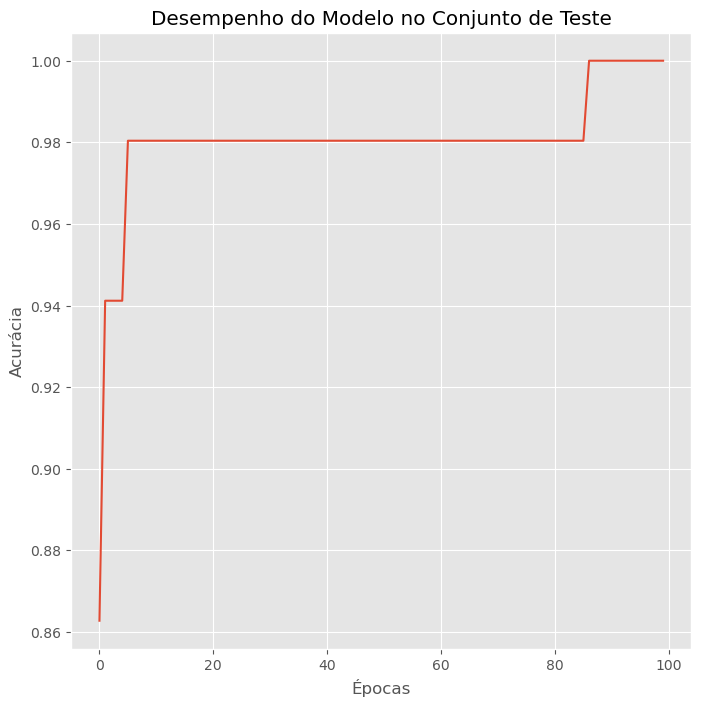

In [97]:
# Pacotes gráficos
%matplotlib inline
import matplotlib.pyplot as plt

# Acurácia do teste
acuracia_teste = historico.history['val_accuracy']

# Gráfico com a evolução do treinamento
plt.figure(figsize=(8, 8))
plt.style.use('ggplot')
plt.plot(acuracia_teste)
plt.title('Desempenho do Modelo no Conjunto de Teste')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.show()


**Chega em uma determinada Época que o modelo entra em overfit**. Por isto vamos ajusta-lo para testar com outras densidades

###  Melhorando os hiperparamentros

In [128]:
def treina_rna(x_train, y_train, x_test, y_test, nnc1, nnc2):
    # Definição do Modelo RNA
    model = keras.Sequential([
        layers.Dense(nnc1, activation='relu', input_dim=x_train.shape[1]),
        layers.Dense(nnc2, activation='relu'),
        layers.Dense(3, activation='softmax')  # Ajuste para 3 classes de saída
    ])

    # Compilação do Modelo
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])

    # Treinamento do Modelo RNA
    historico = model.fit(x=x_train, 
                          y=y_train,
                          epochs=50,  # Reduzindo para 50 épocas
                          batch_size=32,
                          validation_split=0.1,
                          verbose=0)

    # Avaliação do Desempenho do Modelo RNA no conjunto de teste
    _, metric_test = model.evaluate(x_test, y_test, verbose=0)

    return model, metric_test


In [129]:
%%time
lst_models = list()
lst_nnc1 = list()
lst_nnc2 = list()
acc_test = list()

id_model = 0
for nnc1 in range(24, 32):
    for nnc2 in range(24, 32):
        print(f'Treinando Modelo {id_model}')
        lst_nnc1.append(nnc1)
        lst_nnc2.append(nnc2)
        modelo, acc = treina_rna(x_train2, y_train2, 
                                 x_test2, y_test2,
                                 nnc1, nnc2)
        lst_models.append(modelo)
        acc_test.append(acc)
        id_model += 1


Treinando Modelo 0
Treinando Modelo 1
Treinando Modelo 2
Treinando Modelo 3
Treinando Modelo 4
Treinando Modelo 5
Treinando Modelo 6
Treinando Modelo 7
Treinando Modelo 8
Treinando Modelo 9
Treinando Modelo 10
Treinando Modelo 11
Treinando Modelo 12
Treinando Modelo 13
Treinando Modelo 14
Treinando Modelo 15
Treinando Modelo 16
Treinando Modelo 17
Treinando Modelo 18
Treinando Modelo 19
Treinando Modelo 20
Treinando Modelo 21
Treinando Modelo 22
Treinando Modelo 23
Treinando Modelo 24
Treinando Modelo 25
Treinando Modelo 26
Treinando Modelo 27
Treinando Modelo 28
Treinando Modelo 29
Treinando Modelo 30
Treinando Modelo 31
Treinando Modelo 32
Treinando Modelo 33
Treinando Modelo 34
Treinando Modelo 35
Treinando Modelo 36
Treinando Modelo 37
Treinando Modelo 38
Treinando Modelo 39
Treinando Modelo 40
Treinando Modelo 41
Treinando Modelo 42
Treinando Modelo 43
Treinando Modelo 44
Treinando Modelo 45
Treinando Modelo 46
Treinando Modelo 47
Treinando Modelo 48
Treinando Modelo 49
Treinando 

In [130]:
import pandas as pd

busca_rna = pd.DataFrame(list(zip(lst_nnc1, lst_nnc2, acc_test, lst_models)), 
                        columns=['Num Neuronios C1',
                                 'Num Neuronios C2',
                                 'Accuracy Test',
                                 'Modelo'
                                ])

busca_rna.sort_values('Accuracy Test', ascending=False)


,Num Neuronios C1,Num Neuronios C2,Accuracy Test,Modelo
0,24,24,0.944954,<keras.engine.sequential.Sequential object at ...
60,31,28,0.940367,<keras.engine.sequential.Sequential object at ...
2,24,26,0.935780,<keras.engine.sequential.Sequential object at ...
3,24,27,0.935780,<keras.engine.sequential.Sequential object at ...
35,28,27,0.935780,<keras.engine.sequential.Sequential object at ...
...,...,...,...,...
62,31,30,0.908257,<keras.engine.sequential.Sequential object at ...
37,28,29,0.903670,<keras.engine.sequential.Sequential object at ...
48,30,24,0.903670,<keras.engine.sequential.Sequential object at ...
56,31,24,0.903670,<keras.engine.sequential.Sequential object at ...


**O modelo que teve melhor acurácia foi o primeiro modelo com 24 neuronios na primeira camada e 24 na segunda**

In [131]:
modelo_selecionado = busca_rna.loc[0]['Modelo']
modelo_selecionado

In [132]:
# Exportando o modelo para um arquivo
joblib.dump(modelo_selecionado, 'modelo_redes_neurais.pkl')

['modelo_redes_neurais.pkl']

In [143]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf

# Carregando os stop words
df_stop = pd.read_csv('stop_words_novo.csv')

# Carregando o modelo a partir do arquivo
modelo = joblib.load('modelo_redes_neurais.pkl')

# Mapeamento das classes
mapa_classes = {
    0: 'Felicidade',
    1: 'Tristeza',
    2: 'Raiva'
}

# Ajustar o CountVectorizer
countvec = CountVectorizer(ngram_range=(1, 2))
countvec.fit(df_stop['Frase'])

# Função de previsão eficiente usando TensorFlow
def prever_classe(frase_vetorizada):
    return modelo.predict(frase_vetorizada, verbose=0)

while True:
    frase = input("Digite uma frase (ou 'exit' para sair): ")
    if frase.lower() == 'exit':
        print("Programa encerrado.")
        break

    # Vetorização da frase de teste usando o mesmo CountVectorizer ajustado
    frase_vetorizada = countvec.transform([frase])

    # Converter a matriz esparsa em um tensor
    frase_vetorizada_tensor = tf.convert_to_tensor(frase_vetorizada.toarray())

    # Fazer a previsão
    classe_prevista_prob = prever_classe(frase_vetorizada_tensor)
    classe_prevista = tf.argmax(classe_prevista_prob, axis=1).numpy()[0]
    classe_prevista_nome = mapa_classes[classe_prevista]
    print(frase, "->", classe_prevista_nome)


Digite uma frase (ou 'exit' para sair): bom dia mundo
bom dia mundo -> Felicidade
Digite uma frase (ou 'exit' para sair): transito horrivel
transito horrivel -> Felicidade
Digite uma frase (ou 'exit' para sair): que raiva
que raiva -> Raiva
Digite uma frase (ou 'exit' para sair): exit
Programa encerrado.
